## CIFAR-10

In [34]:
import keras

m_c = keras.models.load_model('cifar/models/shadow_models/0.1/train/0.keras')

In [13]:
m_c.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization             │ (None, 32, 32, 32)     │            64 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_1           │ (None, 16, 16, 32)     │            64 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_2           │ (None, 8, 8, 64)       │           128 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ group_normalization_3           │ (None, 512)            │         1,024 │
│ (GroupNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,679,552 (6.41 MB)

 Trainable params: 559,850 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,119,702 (4.27 MB)

In [375]:
wb_test = load_model_params(50, all_y, base_path, 'test')

In [468]:
from common.whitebox_utils import get_dataset

base_path = "cifar/models/shadow_models"

ds = get_dataset(200, base_path, 'train')
ds_test = get_dataset(50, base_path, 'test)

conv_1 weights: KerasVariable shape=(3, 3, 3, 32)
3x3 filter für 3 channels, 32 stück
Die Reihenfolge *innerhalb* der filter ist wichtig, aber die Reihenfolge der filter selbst ist nicht relevant.

In [7]:
from keras import layers
from common.whitebox_utils import WeightsSplitter, BiasSplitter, ConvSplitter, transform_input_name


In [15]:
adv_inputs_c = do_read_single_model_params(m_c)

In [16]:
meta_clf_c = get_wb_meta_clf(adv_inputs_c)

In [17]:
meta_clf.save("cifar/models/wb-cifar-meta-untrained.keras")

In [470]:
meta_clf = keras.models.load_model("wb-meta.keras")

In [500]:
meta_clf.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.MeanAbsoluteError(), metrics=[keras.metrics.R2Score()])

In [35]:
ds_test = tf.data.Dataset.load("cifar/data/white-box/test-data")

In [36]:
ds = tf.data.Dataset.load("cifar/data/white-box/train-data")

In [37]:
ds_test_batched = ds_test.batch(8)

In [38]:
ds_train = ds.shuffle(1800).batch(32, drop_remainder=True)

In [39]:
checkpoint_filepath = "cifar/models/manual_checkpoints/wb-meta/best.weights.h5"
currentmax = 0.4
for i in range(50):
    meta_clf_c = get_wb_meta_clf(adv_inputs_c)
    meta_clf_c.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.MeanAbsoluteError(), metrics=[keras.metrics.R2Score()])
    history = meta_clf_c.fit(
        ds_train, epochs=70, 
        validation_data=ds_test_batched, 
        callbacks=[
            keras.callbacks.EarlyStopping('val_r2_score', patience=5),
            keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='val_r2_score',
                mode='max',
                save_best_only=True)
        ])
    newmax = max(history.history['val_r2_score'])
    if newmax > currentmax:
        print(f"new max r2: {newmax}")
        currentmax = newmax
        meta_clf_c.load_weights(checkpoint_filepath)
        meta_clf_c.save_weights(f"cifar/models/wb_adv_cifar_{round(newmax, 2)}_test_r2.weights.h5")

Epoch 1/70


2024-04-29 10:20:39.911701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1535 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 1:38:37 108s/step - loss: 0.7182 - r2_score: -11.1558

2024-04-29 10:20:42.862992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 157s 890ms/step - loss: 0.7303 - r2_score: -12.0703 - val_loss: 0.5593 - val_r2_score: -5.6755
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - loss: 0.4892 - r2_score: -4.6286 - val_loss: 0.4000 - val_r2_score: -2.6142
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - loss: 0.3493 - r2_score: -1.9949 - val_loss: 0.3799 - val_r2_score: -2.1517
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 293ms/step - loss: 0.2720 - r2_score: -0.9403 - val_loss: 0.3038 - val_r2_score: -0.9909
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - loss: 0.2474 - r2_score: -0.4353 - val_loss: 0.2534 - val_r2_score: -0.3319
Epoch 6/70


2024-04-29 10:23:08.210706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1766 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.2517 - r2_score: -0.3517 

2024-04-29 10:23:08.441415: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - loss: 0.2026 - r2_score: 0.0192 - val_loss: 0.2398 - val_r2_score: -0.1598
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - loss: 0.1879 - r2_score: 0.2052 - val_loss: 0.1976 - val_r2_score: 0.2077
Epoch 8/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - loss: 0.1664 - r2_score: 0.3014 - val_loss: 0.1682 - val_r2_score: 0.3831
Epoch 9/70


2024-04-29 10:24:14.214460: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1689 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:07 11s/step - loss: 0.1741 - r2_score: 0.0886

2024-04-29 10:24:14.778016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 224ms/step - loss: 0.1629 - r2_score: 0.3609 - val_loss: 0.1702 - val_r2_score: 0.3933
Epoch 10/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - loss: 0.1493 - r2_score: 0.4337 - val_loss: 0.1520 - val_r2_score: 0.4124
Epoch 11/70


2024-04-29 10:24:56.214063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1694 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:09 11s/step - loss: 0.1651 - r2_score: -0.1141

2024-04-29 10:24:56.750348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 181ms/step - loss: 0.1543 - r2_score: 0.4125 - val_loss: 0.1527 - val_r2_score: 0.4674
Epoch 12/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - loss: 0.1449 - r2_score: 0.4473 - val_loss: 0.1446 - val_r2_score: 0.4714
Epoch 13/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step - loss: 0.1491 - r2_score: 0.4053 - val_loss: 0.1469 - val_r2_score: 0.4881
Epoch 14/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 223ms/step - loss: 0.1482 - r2_score: 0.4564 - val_loss: 0.1501 - val_r2_score: 0.4905
Epoch 15/70


2024-04-29 10:26:15.104214: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1756 of 1800
2024-04-29 10:26:15.265374: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - loss: 0.1406 - r2_score: 0.4884 - val_loss: 0.1407 - val_r2_score: 0.5090
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - loss: 0.1420 - r2_score: 0.4924 - val_loss: 0.1408 - val_r2_score: 0.5018
Epoch 17/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - loss: 0.1396 - r2_score: 0.4888 - val_loss: 0.1409 - val_r2_score: 0.5149
Epoch 18/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 186ms/step - loss: 0.1364 - r2_score: 0.4975 - val_loss: 0.1396 - val_r2_score: 0.5181
Epoch 19/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - loss: 0.1331 - r2_score: 0.5346 - val_loss: 0.1380 - val_r2_score: 0.5213
Epoch 20/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - loss: 0.1404 - r2_score: 0.4942 - val_loss: 0.1368 - val_r2_score: 0.4875
Epoch 21/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 216ms/step - loss: 0.1348 - r2_score: 0.5040 - val_loss: 0.1405 - val_r2_score: 0.5255
Epoch 22/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - loss: 0.1359 - r2_score: 0.5288 - val_loss: 0.

2024-04-29 10:29:52.973023: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1562 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:39 13s/step - loss: 0.1053 - r2_score: 0.6392

2024-04-29 10:29:54.954873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 161ms/step - loss: 0.1350 - r2_score: 0.5175 - val_loss: 0.1332 - val_r2_score: 0.5182
Epoch 28/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - loss: 0.1268 - r2_score: 0.5477 - val_loss: 0.1395 - val_r2_score: 0.5453
Epoch 29/70


2024-04-29 10:30:33.373997: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1720 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:14 11s/step - loss: 0.1523 - r2_score: 0.4074

2024-04-29 10:30:34.037015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 207ms/step - loss: 0.1324 - r2_score: 0.5244 - val_loss: 0.1330 - val_r2_score: 0.5463
Epoch 30/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.1317 - r2_score: 0.5272 - val_loss: 0.1345 - val_r2_score: 0.5247
Epoch 31/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - loss: 0.1336 - r2_score: 0.5203 - val_loss: 0.1351 - val_r2_score: 0.5482
Epoch 32/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - loss: 0.1297 - r2_score: 0.5658 - val_loss: 0.1359 - val_r2_score: 0.5410
Epoch 33/70


2024-04-29 10:31:47.804302: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1686 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.1637 - r2_score: 0.3412  

2024-04-29 10:31:48.451043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - loss: 0.1338 - r2_score: 0.5287 - val_loss: 0.1408 - val_r2_score: 0.5483
Epoch 34/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - loss: 0.1321 - r2_score: 0.5552 - val_loss: 0.1338 - val_r2_score: 0.5327
Epoch 35/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - loss: 0.1298 - r2_score: 0.5537 - val_loss: 0.1315 - val_r2_score: 0.5330
Epoch 36/70


2024-04-29 10:32:42.167060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1758 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.1249 - r2_score: 0.6082 

2024-04-29 10:32:42.406386: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 149ms/step - loss: 0.1306 - r2_score: 0.5667 - val_loss: 0.1370 - val_r2_score: 0.5430
Epoch 37/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - loss: 0.1324 - r2_score: 0.5419 - val_loss: 0.1324 - val_r2_score: 0.5147
Epoch 38/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 114ms/step - loss: 0.1245 - r2_score: 0.5801 - val_loss: 0.1322 - val_r2_score: 0.5475
new max r2: 0.5482620000839233
Epoch 1/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 157s 1s/step - loss: 0.7206 - r2_score: -11.7167 - val_loss: 1.0093 - val_r2_score: -17.1041
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 185ms/step - loss: 0.4461 - r2_score: -4.0370 - val_loss: 0.5271 - val_r2_score: -4.5923
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - loss: 0.3201 - r2_score: -1.3663 - val_loss: 0.3657 - val_r2_score: -1.8557
Epoch 4/70
 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.2596 - r2_score: -0.6252 

2024-04-29 10:37:17.796581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1794 of 1800
2024-04-29 10:37:17.826182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 191ms/step - loss: 0.2637 - r2_score: -0.6454 - val_loss: 0.3312 - val_r2_score: -1.2561
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - loss: 0.2131 - r2_score: -0.0846 - val_loss: 0.2772 - val_r2_score: -0.5578
Epoch 6/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 274ms/step - loss: 0.1874 - r2_score: 0.1378 - val_loss: 0.2054 - val_r2_score: 0.1305
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 193ms/step - loss: 0.1731 - r2_score: 0.2877 - val_loss: 0.1817 - val_r2_score: 0.3124
Epoch 8/70


2024-04-29 10:38:41.646891: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1501 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.1655 - r2_score: 0.3789 

2024-04-29 10:38:43.606992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 226ms/step - loss: 0.1638 - r2_score: 0.3445 - val_loss: 0.1833 - val_r2_score: 0.3270
Epoch 9/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - loss: 0.1477 - r2_score: 0.4385 - val_loss: 0.1631 - val_r2_score: 0.4292
Epoch 10/70
 1/56 ━━━━━━━━━━━━━━━━━━━━ 9:42 11s/step - loss: 0.1359 - r2_score: 0.3794

2024-04-29 10:39:26.807511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1788 of 1800
2024-04-29 10:39:26.855117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - loss: 0.1566 - r2_score: 0.4101 - val_loss: 0.1493 - val_r2_score: 0.4627
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 260ms/step - loss: 0.1557 - r2_score: 0.4114 - val_loss: 0.1431 - val_r2_score: 0.4701
Epoch 12/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - loss: 0.1442 - r2_score: 0.4565 - val_loss: 0.1412 - val_r2_score: 0.4639
Epoch 13/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 271ms/step - loss: 0.1462 - r2_score: 0.4538 - val_loss: 0.1406 - val_r2_score: 0.4745
Epoch 14/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - loss: 0.1489 - r2_score: 0.4627 - val_loss: 0.1370 - val_r2_score: 0.4717
Epoch 15/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - loss: 0.1398 - r2_score: 0.4894 - val_loss: 0.1399 - val_r2_score: 0.5132
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 206ms/step - loss: 0.1395 - r2_score: 0.4839 - val_loss: 0.1405 - val_r2_score: 0.5191
Epoch 17/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - loss: 0.1392 - r2_score: 0.5044 - val_loss: 0.

2024-04-29 10:42:21.536993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1620 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.1438 - r2_score: 0.5702 

2024-04-29 10:42:22.544391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 234ms/step - loss: 0.1388 - r2_score: 0.5011 - val_loss: 0.1414 - val_r2_score: 0.5320
Epoch 20/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 134ms/step - loss: 0.1398 - r2_score: 0.5093 - val_loss: 0.1346 - val_r2_score: 0.4680
Epoch 21/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - loss: 0.1401 - r2_score: 0.4607 - val_loss: 0.1339 - val_r2_score: 0.5297
Epoch 22/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - loss: 0.1373 - r2_score: 0.4757 - val_loss: 0.1408 - val_r2_score: 0.5332
Epoch 23/70


2024-04-29 10:43:42.523795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1777 of 1800
2024-04-29 10:43:42.648282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - loss: 0.1385 - r2_score: 0.4949 - val_loss: 0.1329 - val_r2_score: 0.4790
Epoch 24/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 216ms/step - loss: 0.1311 - r2_score: 0.5176 - val_loss: 0.1341 - val_r2_score: 0.5423
Epoch 25/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - loss: 0.1452 - r2_score: 0.4944 - val_loss: 0.1339 - val_r2_score: 0.5307
Epoch 26/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - loss: 0.1328 - r2_score: 0.5100 - val_loss: 0.1304 - val_r2_score: 0.5207
Epoch 27/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - loss: 0.1321 - r2_score: 0.5158 - val_loss: 0.1327 - val_r2_score: 0.5370
Epoch 28/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - loss: 0.1312 - r2_score: 0.5240 - val_loss: 0.1299 - val_r2_score: 0.5164
Epoch 29/70


2024-04-29 10:45:31.846840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1639 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:35 12s/step - loss: 0.1141 - r2_score: 0.6625

2024-04-29 10:45:32.957146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 150ms/step - loss: 0.1368 - r2_score: 0.5111 - val_loss: 0.1299 - val_r2_score: 0.5077
Epoch 1/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 887ms/step - loss: 0.9768 - r2_score: -22.3314 - val_loss: 0.4770 - val_r2_score: -4.3386
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - loss: 0.5124 - r2_score: -5.2828 - val_loss: 0.3871 - val_r2_score: -2.5350
Epoch 3/70


2024-04-29 10:48:59.022112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1283 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.3724 - r2_score: -2.2389  

2024-04-29 10:49:02.016450: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 208ms/step - loss: 0.3768 - r2_score: -2.4626 - val_loss: 0.3654 - val_r2_score: -2.0179
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - loss: 0.2931 - r2_score: -1.0310 - val_loss: 0.2947 - val_r2_score: -0.9052
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - loss: 0.2433 - r2_score: -0.3977 - val_loss: 0.2464 - val_r2_score: -0.2663
Epoch 6/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - loss: 0.2089 - r2_score: -0.1224 - val_loss: 0.2044 - val_r2_score: 0.1379
Epoch 7/70


2024-04-29 10:50:26.789360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1513 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1935 - r2_score: -0.0140  

2024-04-29 10:50:27.905234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 206ms/step - loss: 0.1852 - r2_score: 0.1490 - val_loss: 0.1981 - val_r2_score: 0.1995
Epoch 8/70


2024-04-29 10:50:49.631574: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1688 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.1476 - r2_score: 0.2535 

2024-04-29 10:50:50.111824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 250ms/step - loss: 0.1677 - r2_score: 0.2659 - val_loss: 0.1696 - val_r2_score: 0.3750
Epoch 9/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - loss: 0.1642 - r2_score: 0.3548 - val_loss: 0.1676 - val_r2_score: 0.4100
Epoch 10/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - loss: 0.1568 - r2_score: 0.4218 - val_loss: 0.1627 - val_r2_score: 0.4415
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - loss: 0.1500 - r2_score: 0.4463 - val_loss: 0.1475 - val_r2_score: 0.4720
Epoch 12/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - loss: 0.1486 - r2_score: 0.4474 - val_loss: 0.1445 - val_r2_score: 0.4723
Epoch 13/70


2024-04-29 10:52:40.562594: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1703 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.1396 - r2_score: 0.4980  

2024-04-29 10:52:40.994889: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 236ms/step - loss: 0.1411 - r2_score: 0.4980 - val_loss: 0.1427 - val_r2_score: 0.5011
Epoch 14/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - loss: 0.1416 - r2_score: 0.4765 - val_loss: 0.1491 - val_r2_score: 0.5073
Epoch 15/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - loss: 0.1406 - r2_score: 0.4927 - val_loss: 0.1454 - val_r2_score: 0.5221
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - loss: 0.1451 - r2_score: 0.4864 - val_loss: 0.1370 - val_r2_score: 0.5112
Epoch 17/70


2024-04-29 10:54:03.967830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1617 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1403 - r2_score: 0.4761  

2024-04-29 10:54:05.280791: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - loss: 0.1395 - r2_score: 0.5023 - val_loss: 0.1380 - val_r2_score: 0.4840
Epoch 18/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - loss: 0.1328 - r2_score: 0.5373 - val_loss: 0.1394 - val_r2_score: 0.5352
Epoch 19/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 129ms/step - loss: 0.1391 - r2_score: 0.4723 - val_loss: 0.1329 - val_r2_score: 0.4977
Epoch 20/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - loss: 0.1352 - r2_score: 0.4887 - val_loss: 0.1380 - val_r2_score: 0.5206
Epoch 21/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - loss: 0.1425 - r2_score: 0.4626 - val_loss: 0.1347 - val_r2_score: 0.5274
Epoch 22/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - loss: 0.1399 - r2_score: 0.4970 - val_loss: 0.1326 - val_r2_score: 0.5345
Epoch 23/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - loss: 0.1344 - r2_score: 0.5153 - val_loss: 0.1314 - val_r2_score: 0.5327
Epoch 1/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 159s 878ms/step - loss: 0.8866 - r2_score: -18.5239 - val_loss: 

2024-04-29 11:00:14.746807: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1712 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.2425 - r2_score: -0.3587  

2024-04-29 11:00:15.155062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 209ms/step - loss: 0.2435 - r2_score: -0.3957 - val_loss: 0.2547 - val_r2_score: -0.3845
Epoch 6/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step - loss: 0.2030 - r2_score: -0.0011 - val_loss: 0.2115 - val_r2_score: 0.0430
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step - loss: 0.1853 - r2_score: 0.2029 - val_loss: 0.1814 - val_r2_score: 0.2989
Epoch 8/70


2024-04-29 11:01:21.892610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1758 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 9:38 11s/step - loss: 0.1805 - r2_score: 0.4225

2024-04-29 11:01:22.177901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 180ms/step - loss: 0.1683 - r2_score: 0.3152 - val_loss: 0.1684 - val_r2_score: 0.3968
Epoch 9/70
 1/56 ━━━━━━━━━━━━━━━━━━━━ 9:39 11s/step - loss: 0.1408 - r2_score: 0.5425

2024-04-29 11:01:42.603749: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1795 of 1800
2024-04-29 11:01:42.649198: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - loss: 0.1567 - r2_score: 0.4163 - val_loss: 0.1630 - val_r2_score: 0.4411
Epoch 10/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - loss: 0.1541 - r2_score: 0.4263 - val_loss: 0.1488 - val_r2_score: 0.4801
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - loss: 0.1529 - r2_score: 0.4386 - val_loss: 0.1541 - val_r2_score: 0.4848
Epoch 12/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - loss: 0.1426 - r2_score: 0.4899 - val_loss: 0.1445 - val_r2_score: 0.5159
Epoch 13/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - loss: 0.1442 - r2_score: 0.4843 - val_loss: 0.1451 - val_r2_score: 0.5220
Epoch 14/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 199ms/step - loss: 0.1401 - r2_score: 0.4839 - val_loss: 0.1407 - val_r2_score: 0.5305
Epoch 15/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - loss: 0.1393 - r2_score: 0.5254 - val_loss: 0.1482 - val_r2_score: 0.5238
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - loss: 0.1384 - r2_score: 0.5086 - val_loss: 0.

2024-04-29 11:04:25.581631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1797 of 1800
2024-04-29 11:04:25.592587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - loss: 0.1441 - r2_score: 0.4962 - val_loss: 0.1373 - val_r2_score: 0.5325
Epoch 18/70


2024-04-29 11:04:46.734601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1687 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:08 11s/step - loss: 0.1473 - r2_score: 0.4804

2024-04-29 11:04:47.500549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 244ms/step - loss: 0.1343 - r2_score: 0.5258 - val_loss: 0.1376 - val_r2_score: 0.5377
Epoch 19/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - loss: 0.1356 - r2_score: 0.4844 - val_loss: 0.1348 - val_r2_score: 0.5421
Epoch 20/70
 1/56 ━━━━━━━━━━━━━━━━━━━━ 9:34 10s/step - loss: 0.1201 - r2_score: 0.7098

2024-04-29 11:05:30.227304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1785 of 1800
2024-04-29 11:05:30.333043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - loss: 0.1360 - r2_score: 0.5239 - val_loss: 0.1334 - val_r2_score: 0.5383
Epoch 21/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 132ms/step - loss: 0.1341 - r2_score: 0.5531 - val_loss: 0.1366 - val_r2_score: 0.5374
Epoch 22/70


2024-04-29 11:06:04.480145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1745 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:04 11s/step - loss: 0.1379 - r2_score: 0.4407

2024-04-29 11:06:04.988331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 113ms/step - loss: 0.1354 - r2_score: 0.5241 - val_loss: 0.1367 - val_r2_score: 0.5389
Epoch 23/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - loss: 0.1359 - r2_score: 0.5097 - val_loss: 0.1365 - val_r2_score: 0.5502
Epoch 24/70


2024-04-29 11:06:39.986298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1661 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:16 11s/step - loss: 0.1253 - r2_score: 0.5589

2024-04-29 11:06:40.679990: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - loss: 0.1334 - r2_score: 0.5587 - val_loss: 0.1318 - val_r2_score: 0.5101
Epoch 25/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - loss: 0.1338 - r2_score: 0.5345 - val_loss: 0.1406 - val_r2_score: 0.4488
Epoch 26/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - loss: 0.1342 - r2_score: 0.5254 - val_loss: 0.1339 - val_r2_score: 0.5107
Epoch 27/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - loss: 0.1331 - r2_score: 0.5109 - val_loss: 0.1336 - val_r2_score: 0.5530
Epoch 28/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - loss: 0.1360 - r2_score: 0.5320 - val_loss: 0.1324 - val_r2_score: 0.5197
Epoch 29/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - loss: 0.1326 - r2_score: 0.5547 - val_loss: 0.1333 - val_r2_score: 0.5491
Epoch 30/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - loss: 0.1325 - r2_score: 0.5316 - val_loss: 0.1320 - val_r2_score: 0.5611
Epoch 31/70


2024-04-29 11:08:45.666775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1383 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.1557 - r2_score: 0.4024  

2024-04-29 11:08:48.345029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 93ms/step - loss: 0.1329 - r2_score: 0.5467 - val_loss: 0.1407 - val_r2_score: 0.4495
Epoch 32/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - loss: 0.1311 - r2_score: 0.5483 - val_loss: 0.1304 - val_r2_score: 0.5481
Epoch 33/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 145ms/step - loss: 0.1324 - r2_score: 0.5305 - val_loss: 0.1314 - val_r2_score: 0.5579
Epoch 34/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 120ms/step - loss: 0.1329 - r2_score: 0.5366 - val_loss: 0.1353 - val_r2_score: 0.5603
Epoch 35/70


2024-04-29 11:09:53.082800: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1213 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - loss: 0.1275 - r2_score: 0.3947  

2024-04-29 11:09:56.632532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - loss: 0.1353 - r2_score: 0.5239 - val_loss: 0.1318 - val_r2_score: 0.5247
new max r2: 0.5610544085502625
Epoch 1/70


2024-04-29 11:12:12.907111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1734 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 1:27:22 95s/step - loss: 1.3853 - r2_score: -43.1111

2024-04-29 11:12:13.183413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 835ms/step - loss: 0.9573 - r2_score: -22.7006 - val_loss: 0.7417 - val_r2_score: -10.1564
Epoch 2/70


2024-04-29 11:13:09.257388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1713 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 9:44 11s/step - loss: 0.5536 - r2_score: -7.7592

2024-04-29 11:13:09.741048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 264ms/step - loss: 0.4861 - r2_score: -4.6762 - val_loss: 0.4410 - val_r2_score: -3.3208
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 232ms/step - loss: 0.3290 - r2_score: -1.6058 - val_loss: 0.3956 - val_r2_score: -2.3613
Epoch 4/70


2024-04-29 11:13:55.222995: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1731 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 9:44 11s/step - loss: 0.2463 - r2_score: -0.3756

2024-04-29 11:13:55.593918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - loss: 0.2817 - r2_score: -0.8070 - val_loss: 0.2824 - val_r2_score: -0.7330
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - loss: 0.2335 - r2_score: -0.3459 - val_loss: 0.2523 - val_r2_score: -0.3553
Epoch 6/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - loss: 0.1995 - r2_score: 0.0283 - val_loss: 0.1963 - val_r2_score: 0.1767
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 250ms/step - loss: 0.1825 - r2_score: 0.2103 - val_loss: 0.1748 - val_r2_score: 0.3209
Epoch 8/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - loss: 0.1697 - r2_score: 0.3186 - val_loss: 0.1676 - val_r2_score: 0.3751
Epoch 9/70


2024-04-29 11:15:43.838759: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1548 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.1582 - r2_score: 0.4016  

2024-04-29 11:15:45.031875: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 235ms/step - loss: 0.1663 - r2_score: 0.3497 - val_loss: 0.1575 - val_r2_score: 0.4176
Epoch 10/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 254ms/step - loss: 0.1560 - r2_score: 0.3789 - val_loss: 0.1525 - val_r2_score: 0.4467
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - loss: 0.1511 - r2_score: 0.4155 - val_loss: 0.1462 - val_r2_score: 0.4471
Epoch 12/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 279ms/step - loss: 0.1449 - r2_score: 0.4504 - val_loss: 0.1445 - val_r2_score: 0.4759
Epoch 13/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - loss: 0.1459 - r2_score: 0.4540 - val_loss: 0.1469 - val_r2_score: 0.4816
Epoch 14/70


2024-04-29 11:17:35.050900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1308 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.1645 - r2_score: 0.3253 

2024-04-29 11:17:38.578094: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 197ms/step - loss: 0.1500 - r2_score: 0.4246 - val_loss: 0.1534 - val_r2_score: 0.4835
Epoch 15/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 244ms/step - loss: 0.1438 - r2_score: 0.4579 - val_loss: 0.1411 - val_r2_score: 0.4879
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 219ms/step - loss: 0.1441 - r2_score: 0.4706 - val_loss: 0.1441 - val_r2_score: 0.4993
Epoch 17/70


2024-04-29 11:18:43.244444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1573 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:36 12s/step - loss: 0.1640 - r2_score: -0.3425

2024-04-29 11:18:44.452824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - loss: 0.1465 - r2_score: 0.4194 - val_loss: 0.1462 - val_r2_score: 0.3522
Epoch 18/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - loss: 0.1412 - r2_score: 0.4502 - val_loss: 0.1359 - val_r2_score: 0.4740
Epoch 19/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 184ms/step - loss: 0.1373 - r2_score: 0.5036 - val_loss: 0.1355 - val_r2_score: 0.4815
Epoch 20/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - loss: 0.1419 - r2_score: 0.4532 - val_loss: 0.1391 - val_r2_score: 0.5154
Epoch 21/70


2024-04-29 11:19:58.613767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1452 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:44 13s/step - loss: 0.1770 - r2_score: 0.4612

2024-04-29 11:20:00.925941: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 207ms/step - loss: 0.1423 - r2_score: 0.4952 - val_loss: 0.1364 - val_r2_score: 0.5169
Epoch 22/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - loss: 0.1403 - r2_score: 0.4808 - val_loss: 0.1465 - val_r2_score: 0.4067
Epoch 23/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - loss: 0.1364 - r2_score: 0.4691 - val_loss: 0.1353 - val_r2_score: 0.4738
Epoch 24/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - loss: 0.1368 - r2_score: 0.4961 - val_loss: 0.1397 - val_r2_score: 0.5172
Epoch 25/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - loss: 0.1307 - r2_score: 0.5278 - val_loss: 0.1331 - val_r2_score: 0.4638
Epoch 26/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 121ms/step - loss: 0.1330 - r2_score: 0.5271 - val_loss: 0.1334 - val_r2_score: 0.5062
Epoch 27/70


2024-04-29 11:21:52.107697: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1626 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.1411 - r2_score: 0.4929  

2024-04-29 11:21:53.021925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 175ms/step - loss: 0.1363 - r2_score: 0.5236 - val_loss: 0.1340 - val_r2_score: 0.5032
Epoch 28/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.1322 - r2_score: 0.5395 - val_loss: 0.1328 - val_r2_score: 0.4947
Epoch 29/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - loss: 0.1307 - r2_score: 0.5491 - val_loss: 0.1332 - val_r2_score: 0.5007
Epoch 1/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 859ms/step - loss: 0.7582 - r2_score: -13.1803 - val_loss: 0.9558 - val_r2_score: -16.0624
Epoch 2/70


2024-04-29 11:25:23.544377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1710 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 9:40 11s/step - loss: 0.4671 - r2_score: -4.5101

2024-04-29 11:25:23.976842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - loss: 0.4401 - r2_score: -3.5616 - val_loss: 0.3214 - val_r2_score: -1.2676
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - loss: 0.3145 - r2_score: -1.4322 - val_loss: 0.3212 - val_r2_score: -1.2415
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 204ms/step - loss: 0.2521 - r2_score: -0.4666 - val_loss: 0.2880 - val_r2_score: -0.7732
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 287ms/step - loss: 0.2142 - r2_score: -0.1059 - val_loss: 0.2271 - val_r2_score: -0.0524
Epoch 6/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step - loss: 0.1977 - r2_score: 0.1107 - val_loss: 0.2043 - val_r2_score: 0.1834
Epoch 7/70


2024-04-29 11:27:17.214628: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1325 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.1724 - r2_score: 0.3138  

2024-04-29 11:27:20.969525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 163ms/step - loss: 0.1691 - r2_score: 0.3103 - val_loss: 0.1836 - val_r2_score: 0.3351
Epoch 8/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 216ms/step - loss: 0.1665 - r2_score: 0.3418 - val_loss: 0.1590 - val_r2_score: 0.4529
Epoch 9/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 170ms/step - loss: 0.1575 - r2_score: 0.3848 - val_loss: 0.1478 - val_r2_score: 0.4840
Epoch 10/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - loss: 0.1415 - r2_score: 0.4671 - val_loss: 0.1405 - val_r2_score: 0.4756
Epoch 11/70


2024-04-29 11:28:35.341560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1545 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:42 13s/step - loss: 0.1355 - r2_score: 0.2841

2024-04-29 11:28:37.659156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 180ms/step - loss: 0.1429 - r2_score: 0.4554 - val_loss: 0.1484 - val_r2_score: 0.5104
Epoch 12/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - loss: 0.1471 - r2_score: 0.4493 - val_loss: 0.1404 - val_r2_score: 0.5089
Epoch 13/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - loss: 0.1453 - r2_score: 0.4730 - val_loss: 0.1422 - val_r2_score: 0.5220
Epoch 14/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - loss: 0.1437 - r2_score: 0.4778 - val_loss: 0.1362 - val_r2_score: 0.5056
Epoch 15/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 177ms/step - loss: 0.1413 - r2_score: 0.4669 - val_loss: 0.1353 - val_r2_score: 0.4942
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 107ms/step - loss: 0.1383 - r2_score: 0.5033 - val_loss: 0.1339 - val_r2_score: 0.4878
Epoch 17/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 270ms/step - loss: 0.1445 - r2_score: 0.4604 - val_loss: 0.1428 - val_r2_score: 0.5392
Epoch 18/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 108ms/step - loss: 0.1394 - r2_score: 0.4742 - val_loss: 0.

2024-04-29 11:31:01.428286: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1470 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:26 12s/step - loss: 0.1278 - r2_score: 0.5246

2024-04-29 11:31:03.342228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 180ms/step - loss: 0.1398 - r2_score: 0.4618 - val_loss: 0.1305 - val_r2_score: 0.5309
Epoch 20/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - loss: 0.1341 - r2_score: 0.5127 - val_loss: 0.1352 - val_r2_score: 0.5504
Epoch 21/70


2024-04-29 11:31:44.597522: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1761 of 1800
2024-04-29 11:31:44.775433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 153ms/step - loss: 0.1437 - r2_score: 0.4617 - val_loss: 0.1307 - val_r2_score: 0.5363
Epoch 22/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - loss: 0.1413 - r2_score: 0.4705 - val_loss: 0.1397 - val_r2_score: 0.4643
Epoch 23/70


2024-04-29 11:32:18.073869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1765 of 1800
2024-04-29 11:32:18.266352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 235ms/step - loss: 0.1403 - r2_score: 0.4755 - val_loss: 0.1395 - val_r2_score: 0.5539
Epoch 24/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 241ms/step - loss: 0.1390 - r2_score: 0.5000 - val_loss: 0.1350 - val_r2_score: 0.5573
Epoch 25/70


2024-04-29 11:33:03.422650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1682 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.1258 - r2_score: 0.5653  

2024-04-29 11:33:04.022590: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - loss: 0.1365 - r2_score: 0.5201 - val_loss: 0.1302 - val_r2_score: 0.5113
Epoch 26/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 227ms/step - loss: 0.1369 - r2_score: 0.5010 - val_loss: 0.1385 - val_r2_score: 0.5596
Epoch 27/70


2024-04-29 11:33:41.882971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1655 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.1397 - r2_score: 0.5726  

2024-04-29 11:33:42.599977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 114ms/step - loss: 0.1309 - r2_score: 0.5340 - val_loss: 0.1284 - val_r2_score: 0.5360
Epoch 28/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 128ms/step - loss: 0.1354 - r2_score: 0.5348 - val_loss: 0.1322 - val_r2_score: 0.4888
Epoch 29/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 175ms/step - loss: 0.1358 - r2_score: 0.5196 - val_loss: 0.1274 - val_r2_score: 0.5356
Epoch 30/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - loss: 0.1323 - r2_score: 0.5314 - val_loss: 0.1263 - val_r2_score: 0.5391
Epoch 31/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 278ms/step - loss: 0.1342 - r2_score: 0.5164 - val_loss: 0.1297 - val_r2_score: 0.5634
Epoch 32/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 192ms/step - loss: 0.1306 - r2_score: 0.5423 - val_loss: 0.1349 - val_r2_score: 0.5697
Epoch 33/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 138ms/step - loss: 0.1302 - r2_score: 0.5368 - val_loss: 0.1274 - val_r2_score: 0.5550
Epoch 34/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 180ms/step - loss: 0.1327 - r2_score: 0.5488 - val_loss: 0.

2024-04-29 11:36:45.475579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1598 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:38 12s/step - loss: 0.0973 - r2_score: 0.6891

2024-04-29 11:36:46.761820: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 242ms/step - loss: 0.1314 - r2_score: 0.5520 - val_loss: 0.1305 - val_r2_score: 0.5788
Epoch 38/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - loss: 0.1357 - r2_score: 0.5144 - val_loss: 0.1250 - val_r2_score: 0.5574
Epoch 39/70


2024-04-29 11:37:25.705973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1700 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:14 11s/step - loss: 0.1403 - r2_score: 0.5501

2024-04-29 11:37:26.384536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - loss: 0.1294 - r2_score: 0.5710 - val_loss: 0.1267 - val_r2_score: 0.5576
Epoch 40/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - loss: 0.1259 - r2_score: 0.5644 - val_loss: 0.1256 - val_r2_score: 0.5685
Epoch 41/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 175ms/step - loss: 0.1254 - r2_score: 0.5812 - val_loss: 0.1275 - val_r2_score: 0.5694
Epoch 42/70


2024-04-29 11:38:17.703497: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1719 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.1376 - r2_score: 0.4038  

2024-04-29 11:38:18.235507: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 125ms/step - loss: 0.1311 - r2_score: 0.5399 - val_loss: 0.1302 - val_r2_score: 0.5762
new max r2: 0.5787969827651978
Epoch 1/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 150s 898ms/step - loss: 0.6216 - r2_score: -8.6113 - val_loss: 0.6409 - val_r2_score: -7.7531
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - loss: 0.3958 - r2_score: -2.7363 - val_loss: 0.4486 - val_r2_score: -3.2182
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - loss: 0.2804 - r2_score: -0.8723 - val_loss: 0.3390 - val_r2_score: -1.4270
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - loss: 0.2249 - r2_score: -0.1966 - val_loss: 0.2908 - val_r2_score: -0.9157
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 232ms/step - loss: 0.1885 - r2_score: 0.1437 - val_loss: 0.2467 - val_r2_score: -0.3185
Epoch 6/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 209ms/step - loss: 0.1822 - r2_score: 0.2034 - val_loss: 0.1861 - val_r2_score: 0.2744
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - loss: 0.1649

2024-04-29 11:46:14.491578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1453 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:14 12s/step - loss: 0.1351 - r2_score: 0.4590

2024-04-29 11:46:16.535452: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 185ms/step - loss: 0.1379 - r2_score: 0.4883 - val_loss: 0.1382 - val_r2_score: 0.5498
Epoch 17/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - loss: 0.1359 - r2_score: 0.5219 - val_loss: 0.1395 - val_r2_score: 0.5357
Epoch 18/70


2024-04-29 11:46:54.958579: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1751 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.1556 - r2_score: 0.4867 

2024-04-29 11:46:55.210667: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 146ms/step - loss: 0.1435 - r2_score: 0.4878 - val_loss: 0.1343 - val_r2_score: 0.4844
Epoch 19/70


2024-04-29 11:47:13.691272: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1765 of 1800
2024-04-29 11:47:13.864973: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - loss: 0.1329 - r2_score: 0.5231 - val_loss: 0.1349 - val_r2_score: 0.5628
Epoch 20/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - loss: 0.1335 - r2_score: 0.5202 - val_loss: 0.1371 - val_r2_score: 0.5619
Epoch 21/70
 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.1374 - r2_score: 0.5713 

2024-04-29 11:47:51.279307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1794 of 1800
2024-04-29 11:47:51.304307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 133ms/step - loss: 0.1358 - r2_score: 0.5171 - val_loss: 0.1301 - val_r2_score: 0.5416
Epoch 22/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step - loss: 0.1337 - r2_score: 0.5191 - val_loss: 0.1294 - val_r2_score: 0.5361
Epoch 23/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 190ms/step - loss: 0.1320 - r2_score: 0.5316 - val_loss: 0.1306 - val_r2_score: 0.5661
Epoch 24/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 136ms/step - loss: 0.1293 - r2_score: 0.5453 - val_loss: 0.1296 - val_r2_score: 0.5609
Epoch 25/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - loss: 0.1301 - r2_score: 0.5605 - val_loss: 0.1452 - val_r2_score: 0.5469
Epoch 26/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 122ms/step - loss: 0.1350 - r2_score: 0.5191 - val_loss: 0.1403 - val_r2_score: 0.5597
Epoch 27/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - loss: 0.1351 - r2_score: 0.5306 - val_loss: 0.1312 - val_r2_score: 0.5706
Epoch 28/70


2024-04-29 11:49:56.845348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1693 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:37 12s/step - loss: 0.1262 - r2_score: 0.6350

2024-04-29 11:49:57.861731: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - loss: 0.1300 - r2_score: 0.5762 - val_loss: 0.1284 - val_r2_score: 0.5301
Epoch 29/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 0.1322 - r2_score: 0.5298 - val_loss: 0.1364 - val_r2_score: 0.5684
Epoch 30/70


2024-04-29 11:50:31.132660: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1626 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:56 12s/step - loss: 0.1566 - r2_score: 0.4020

2024-04-29 11:50:32.485644: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 250ms/step - loss: 0.1347 - r2_score: 0.5342 - val_loss: 0.1292 - val_r2_score: 0.5744
Epoch 31/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - loss: 0.1232 - r2_score: 0.5633 - val_loss: 0.1296 - val_r2_score: 0.5460
Epoch 32/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - loss: 0.1361 - r2_score: 0.5213 - val_loss: 0.1276 - val_r2_score: 0.5554
Epoch 33/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - loss: 0.1274 - r2_score: 0.5633 - val_loss: 0.1292 - val_r2_score: 0.5319
Epoch 34/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - loss: 0.1385 - r2_score: 0.4831 - val_loss: 0.1287 - val_r2_score: 0.5659
Epoch 35/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 112ms/step - loss: 0.1330 - r2_score: 0.5164 - val_loss: 0.1363 - val_r2_score: 0.5704
Epoch 1/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 157s 870ms/step - loss: 0.5627 - r2_score: -6.8267 - val_loss: 0.3371 - val_r2_score: -1.5416
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - loss: 0.3526 - r2_score: -1.9784 - val_loss: 

2024-04-29 11:56:55.050548: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1777 of 1800
2024-04-29 11:56:55.187159: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - loss: 0.1578 - r2_score: 0.3898 - val_loss: 0.1517 - val_r2_score: 0.4734
Epoch 8/70


2024-04-29 11:57:17.210683: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1780 of 1800
2024-04-29 11:57:17.340793: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 227ms/step - loss: 0.1532 - r2_score: 0.4248 - val_loss: 0.1536 - val_r2_score: 0.4852
Epoch 9/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 114ms/step - loss: 0.1455 - r2_score: 0.4736 - val_loss: 0.1429 - val_r2_score: 0.4645
Epoch 10/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - loss: 0.1455 - r2_score: 0.4516 - val_loss: 0.1404 - val_r2_score: 0.5051
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - loss: 0.1420 - r2_score: 0.4683 - val_loss: 0.1396 - val_r2_score: 0.5140
Epoch 12/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 231ms/step - loss: 0.1390 - r2_score: 0.4886 - val_loss: 0.1366 - val_r2_score: 0.5223
Epoch 13/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - loss: 0.1375 - r2_score: 0.4974 - val_loss: 0.1383 - val_r2_score: 0.5330
Epoch 14/70


2024-04-29 11:59:16.389435: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1427 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:56 13s/step - loss: 0.1658 - r2_score: 0.5097

2024-04-29 11:59:18.940513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 134ms/step - loss: 0.1404 - r2_score: 0.5086 - val_loss: 0.1355 - val_r2_score: 0.5117
Epoch 15/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - loss: 0.1357 - r2_score: 0.5204 - val_loss: 0.1350 - val_r2_score: 0.5151
Epoch 16/70
 1/56 ━━━━━━━━━━━━━━━━━━━━ 9:34 10s/step - loss: 0.1505 - r2_score: -0.2335

2024-04-29 11:59:54.244151: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1787 of 1800
2024-04-29 11:59:54.320763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - loss: 0.1370 - r2_score: 0.4790 - val_loss: 0.1324 - val_r2_score: 0.5293
Epoch 17/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - loss: 0.1355 - r2_score: 0.5059 - val_loss: 0.1351 - val_r2_score: 0.5569
Epoch 18/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step - loss: 0.1318 - r2_score: 0.5458 - val_loss: 0.1326 - val_r2_score: 0.5513
Epoch 19/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - loss: 0.1331 - r2_score: 0.5377 - val_loss: 0.1336 - val_r2_score: 0.5322
Epoch 20/70


2024-04-29 12:01:07.613030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1740 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.1638 - r2_score: 0.4195 

2024-04-29 12:01:07.909699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step - loss: 0.1397 - r2_score: 0.5220 - val_loss: 0.1359 - val_r2_score: 0.5578
Epoch 21/70


2024-04-29 12:01:30.091912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1634 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.1358 - r2_score: 0.4567  

2024-04-29 12:01:31.183446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - loss: 0.1357 - r2_score: 0.5188 - val_loss: 0.1341 - val_r2_score: 0.4944
Epoch 22/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - loss: 0.1353 - r2_score: 0.5045 - val_loss: 0.1311 - val_r2_score: 0.5163
Epoch 23/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - loss: 0.1339 - r2_score: 0.5394 - val_loss: 0.1342 - val_r2_score: 0.5061
Epoch 24/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 158ms/step - loss: 0.1323 - r2_score: 0.5259 - val_loss: 0.1431 - val_r2_score: 0.5509
Epoch 25/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step - loss: 0.1338 - r2_score: 0.5377 - val_loss: 0.1577 - val_r2_score: 0.5050
Epoch 1/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 743ms/step - loss: 0.7240 - r2_score: -12.0146 - val_loss: 0.6738 - val_r2_score: -8.7298
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 216ms/step - loss: 0.4408 - r2_score: -3.5886 - val_loss: 0.5940 - val_r2_score: -6.1436
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 181ms/step - loss: 0.2946 - r2_score: -1.0420 - val_loss

2024-04-29 12:08:39.403496: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1513 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.1345 - r2_score: 0.3847  

2024-04-29 12:08:41.362680: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - loss: 0.1422 - r2_score: 0.4512 - val_loss: 0.1408 - val_r2_score: 0.4728
Epoch 12/70


2024-04-29 12:09:05.063894: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1614 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.1724 - r2_score: 0.1509  

2024-04-29 12:09:06.060093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - loss: 0.1499 - r2_score: 0.4267 - val_loss: 0.1432 - val_r2_score: 0.4313
Epoch 13/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 210ms/step - loss: 0.1413 - r2_score: 0.4980 - val_loss: 0.1379 - val_r2_score: 0.5059
Epoch 14/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - loss: 0.1420 - r2_score: 0.4848 - val_loss: 0.1387 - val_r2_score: 0.5155
Epoch 15/70


2024-04-29 12:10:05.202788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1420 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.1329 - r2_score: 0.3446  

2024-04-29 12:10:08.073022: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 156ms/step - loss: 0.1453 - r2_score: 0.4664 - val_loss: 0.1362 - val_r2_score: 0.5164
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - loss: 0.1391 - r2_score: 0.5084 - val_loss: 0.1385 - val_r2_score: 0.5223
Epoch 17/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - loss: 0.1374 - r2_score: 0.5060 - val_loss: 0.1438 - val_r2_score: 0.5215
Epoch 18/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - loss: 0.1405 - r2_score: 0.4922 - val_loss: 0.1464 - val_r2_score: 0.5215
Epoch 19/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 178ms/step - loss: 0.1356 - r2_score: 0.5264 - val_loss: 0.1458 - val_r2_score: 0.5257
Epoch 20/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - loss: 0.1400 - r2_score: 0.4968 - val_loss: 0.1338 - val_r2_score: 0.5204
Epoch 21/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - loss: 0.1401 - r2_score: 0.4994 - val_loss: 0.1324 - val_r2_score: 0.5271
Epoch 22/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - loss: 0.1396 - r2_score: 0.5109 - val_loss: 0.

2024-04-29 12:14:28.456847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1784 of 1800
2024-04-29 12:14:28.519882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 120ms/step - loss: 0.1401 - r2_score: 0.5187 - val_loss: 0.1283 - val_r2_score: 0.5364
Epoch 30/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - loss: 0.1266 - r2_score: 0.5525 - val_loss: 0.1378 - val_r2_score: 0.5563
Epoch 31/70


2024-04-29 12:15:04.430767: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1484 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.1289 - r2_score: 0.3785

2024-04-29 12:15:06.029845: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 114ms/step - loss: 0.1419 - r2_score: 0.4678 - val_loss: 0.1545 - val_r2_score: 0.5242
Epoch 32/70


2024-04-29 12:15:22.734243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1522 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:43 13s/step - loss: 0.1576 - r2_score: 0.5152

2024-04-29 12:15:25.056665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - loss: 0.1364 - r2_score: 0.5292 - val_loss: 0.1321 - val_r2_score: 0.5606
Epoch 33/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 123ms/step - loss: 0.1318 - r2_score: 0.5521 - val_loss: 0.1374 - val_r2_score: 0.4334
Epoch 34/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 100ms/step - loss: 0.1285 - r2_score: 0.5734 - val_loss: 0.1282 - val_r2_score: 0.5261
Epoch 35/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 179ms/step - loss: 0.1316 - r2_score: 0.5512 - val_loss: 0.1302 - val_r2_score: 0.5614
Epoch 36/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - loss: 0.1286 - r2_score: 0.5423 - val_loss: 0.1281 - val_r2_score: 0.5515
Epoch 37/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - loss: 0.1289 - r2_score: 0.5699 - val_loss: 0.1269 - val_r2_score: 0.5206
Epoch 38/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 166ms/step - loss: 0.1263 - r2_score: 0.5863 - val_loss: 0.1295 - val_r2_score: 0.5131
Epoch 39/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - loss: 0.1306 - r2_score: 0.5437 - val_loss: 0.

2024-04-29 12:22:20.495361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1719 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:06 11s/step - loss: 0.1672 - r2_score: -0.0062

2024-04-29 12:22:21.077077: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - loss: 0.1566 - r2_score: 0.3673 - val_loss: 0.1531 - val_r2_score: 0.4671
Epoch 8/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - loss: 0.1511 - r2_score: 0.4152 - val_loss: 0.1494 - val_r2_score: 0.4879
Epoch 9/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - loss: 0.1481 - r2_score: 0.4246 - val_loss: 0.1452 - val_r2_score: 0.4920
Epoch 10/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 244ms/step - loss: 0.1421 - r2_score: 0.4226 - val_loss: 0.1396 - val_r2_score: 0.5001
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - loss: 0.1473 - r2_score: 0.4027 - val_loss: 0.1390 - val_r2_score: 0.4600
Epoch 12/70


2024-04-29 12:24:02.293312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1767 of 1800
2024-04-29 12:24:02.437730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - loss: 0.1472 - r2_score: 0.4115 - val_loss: 0.1361 - val_r2_score: 0.4623
Epoch 13/70


2024-04-29 12:24:20.706700: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1628 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:36 12s/step - loss: 0.1506 - r2_score: 0.3180

2024-04-29 12:24:21.900411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - loss: 0.1423 - r2_score: 0.4480 - val_loss: 0.1361 - val_r2_score: 0.4731
Epoch 14/70


2024-04-29 12:24:39.265089: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1492 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.1555 - r2_score: 0.4960  

2024-04-29 12:24:41.105622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 131ms/step - loss: 0.1447 - r2_score: 0.4271 - val_loss: 0.1359 - val_r2_score: 0.4747
Epoch 15/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - loss: 0.1399 - r2_score: 0.4589 - val_loss: 0.1358 - val_r2_score: 0.4911
Epoch 1/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 104s 599ms/step - loss: 0.9469 - r2_score: -21.4060 - val_loss: 1.4505 - val_r2_score: -33.9207
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - loss: 0.5273 - r2_score: -5.6801 - val_loss: 0.4220 - val_r2_score: -2.9615
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 131ms/step - loss: 0.3898 - r2_score: -2.6713 - val_loss: 0.4179 - val_r2_score: -2.7527
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step - loss: 0.2986 - r2_score: -1.1325 - val_loss: 0.3214 - val_r2_score: -1.2376
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 235ms/step - loss: 0.2396 - r2_score: -0.3417 - val_loss: 0.2578 - val_r2_score: -0.4144
Epoch 6/70


2024-04-29 12:28:19.910630: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1723 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.2211 - r2_score: -0.9356  

2024-04-29 12:28:20.395882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - loss: 0.2125 - r2_score: -0.1275 - val_loss: 0.1957 - val_r2_score: 0.1718
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - loss: 0.1808 - r2_score: 0.2349 - val_loss: 0.1687 - val_r2_score: 0.3608
Epoch 8/70


2024-04-29 12:29:00.992771: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1505 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:53 12s/step - loss: 0.1837 - r2_score: 0.0846

2024-04-29 12:29:02.445706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - loss: 0.1650 - r2_score: 0.3196 - val_loss: 0.1591 - val_r2_score: 0.4248
Epoch 9/70


2024-04-29 12:29:22.056944: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1606 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - loss: 0.1974 - r2_score: 0.0062   

2024-04-29 12:29:23.870603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - loss: 0.1624 - r2_score: 0.3472 - val_loss: 0.1663 - val_r2_score: 0.4178
Epoch 10/70


2024-04-29 12:29:41.226070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1526 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.1576 - r2_score: 0.3343  

2024-04-29 12:29:42.579777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 189ms/step - loss: 0.1502 - r2_score: 0.4213 - val_loss: 0.1469 - val_r2_score: 0.4396
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 242ms/step - loss: 0.1512 - r2_score: 0.4209 - val_loss: 0.1439 - val_r2_score: 0.4467
Epoch 12/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - loss: 0.1497 - r2_score: 0.4355 - val_loss: 0.1420 - val_r2_score: 0.4897
Epoch 13/70


2024-04-29 12:30:43.395117: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1638 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1578 - r2_score: 0.3101  

2024-04-29 12:30:44.148384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 199ms/step - loss: 0.1383 - r2_score: 0.4999 - val_loss: 0.1467 - val_r2_score: 0.5089
Epoch 14/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 176ms/step - loss: 0.1426 - r2_score: 0.4979 - val_loss: 0.1462 - val_r2_score: 0.5176
Epoch 15/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - loss: 0.1402 - r2_score: 0.4885 - val_loss: 0.1400 - val_r2_score: 0.5250
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 126ms/step - loss: 0.1360 - r2_score: 0.5151 - val_loss: 0.1417 - val_r2_score: 0.4400
Epoch 17/70


2024-04-29 12:31:59.289062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1484 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:11 12s/step - loss: 0.1895 - r2_score: -0.0496

2024-04-29 12:32:01.126905: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 147ms/step - loss: 0.1437 - r2_score: 0.4544 - val_loss: 0.1357 - val_r2_score: 0.5124
Epoch 18/70


2024-04-29 12:32:19.750164: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1725 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.1210 - r2_score: 0.5147 

2024-04-29 12:32:20.043851: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - loss: 0.1356 - r2_score: 0.4954 - val_loss: 0.1345 - val_r2_score: 0.5148
Epoch 19/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 195ms/step - loss: 0.1478 - r2_score: 0.4405 - val_loss: 0.1343 - val_r2_score: 0.5250
Epoch 20/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - loss: 0.1450 - r2_score: 0.4631 - val_loss: 0.1378 - val_r2_score: 0.4555
Epoch 21/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - loss: 0.1348 - r2_score: 0.5215 - val_loss: 0.1333 - val_r2_score: 0.5070
Epoch 22/70


2024-04-29 12:33:31.011351: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1721 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.1116 - r2_score: 0.6355  

2024-04-29 12:33:31.510446: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 109ms/step - loss: 0.1352 - r2_score: 0.5111 - val_loss: 0.1372 - val_r2_score: 0.4827
Epoch 23/70
 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 1.2140 - r2_score: -48.2830    

2024-04-29 12:35:59.306218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1799 of 1800
2024-04-29 12:35:59.310925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 131s 714ms/step - loss: 0.9076 - r2_score: -19.9814 - val_loss: 0.5595 - val_r2_score: -6.0479
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - loss: 0.5315 - r2_score: -5.7862 - val_loss: 0.3656 - val_r2_score: -2.0665
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 198ms/step - loss: 0.3888 - r2_score: -2.5299 - val_loss: 0.3412 - val_r2_score: -1.6381
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - loss: 0.3078 - r2_score: -1.1866 - val_loss: 0.2978 - val_r2_score: -0.9584
Epoch 5/70


2024-04-29 12:37:46.238847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1723 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.2399 - r2_score: -0.2575

2024-04-29 12:37:46.553768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - loss: 0.2452 - r2_score: -0.4137 - val_loss: 0.2586 - val_r2_score: -0.4075
Epoch 6/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - loss: 0.2266 - r2_score: -0.1689 - val_loss: 0.2099 - val_r2_score: 0.0675
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - loss: 0.1816 - r2_score: 0.1888 - val_loss: 0.1922 - val_r2_score: 0.2282
Epoch 8/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 167ms/step - loss: 0.1715 - r2_score: 0.3020 - val_loss: 0.1680 - val_r2_score: 0.3922
Epoch 9/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - loss: 0.1764 - r2_score: 0.2863 - val_loss: 0.1531 - val_r2_score: 0.4587
Epoch 10/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 215ms/step - loss: 0.1589 - r2_score: 0.4153 - val_loss: 0.1466 - val_r2_score: 0.4794
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - loss: 0.1491 - r2_score: 0.4561 - val_loss: 0.1458 - val_r2_score: 0.4983
Epoch 12/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 203ms/step - loss: 0.1511 - r2_score: 0.4220 - val_loss: 0.1

2024-04-29 12:47:17.965061: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1590 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 1.0287 - r2_score: -25.0562     

2024-04-29 12:47:19.431916: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 168s 1s/step - loss: 0.8335 - r2_score: -16.1702 - val_loss: 0.4955 - val_r2_score: -4.1698
Epoch 2/70


2024-04-29 12:48:30.554551: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1479 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.5261 - r2_score: -5.3511

2024-04-29 12:48:32.157394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 210ms/step - loss: 0.4788 - r2_score: -4.5070 - val_loss: 0.3379 - val_r2_score: -1.5493
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - loss: 0.3277 - r2_score: -1.6984 - val_loss: 0.3406 - val_r2_score: -1.6479
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 205ms/step - loss: 0.2627 - r2_score: -0.6783 - val_loss: 0.3174 - val_r2_score: -1.2057
Epoch 5/70


2024-04-29 12:49:29.850789: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1732 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.2434 - r2_score: -0.2140 

2024-04-29 12:49:30.265253: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - loss: 0.2422 - r2_score: -0.3756 - val_loss: 0.2432 - val_r2_score: -0.2518
Epoch 6/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - loss: 0.1934 - r2_score: 0.1096 - val_loss: 0.1988 - val_r2_score: 0.1826
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - loss: 0.1835 - r2_score: 0.1973 - val_loss: 0.1731 - val_r2_score: 0.3673
Epoch 8/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 203ms/step - loss: 0.1605 - r2_score: 0.3250 - val_loss: 0.1640 - val_r2_score: 0.4244
Epoch 9/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 201ms/step - loss: 0.1516 - r2_score: 0.4235 - val_loss: 0.1498 - val_r2_score: 0.4809
Epoch 10/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - loss: 0.1522 - r2_score: 0.4478 - val_loss: 0.1485 - val_r2_score: 0.4991
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - loss: 0.1458 - r2_score: 0.4928 - val_loss: 0.1438 - val_r2_score: 0.5138
Epoch 12/70


2024-04-29 12:51:56.758007: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1722 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1543 - r2_score: 0.5083 

2024-04-29 12:51:57.268702: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 193ms/step - loss: 0.1456 - r2_score: 0.4781 - val_loss: 0.1380 - val_r2_score: 0.5209
Epoch 13/70


2024-04-29 12:52:18.364689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1668 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:28 11s/step - loss: 0.1209 - r2_score: 0.5504

2024-04-29 12:52:19.267907: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 219ms/step - loss: 0.1409 - r2_score: 0.5044 - val_loss: 0.1376 - val_r2_score: 0.5299
Epoch 14/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - loss: 0.1439 - r2_score: 0.4654 - val_loss: 0.1370 - val_r2_score: 0.5375
Epoch 15/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - loss: 0.1343 - r2_score: 0.5148 - val_loss: 0.1373 - val_r2_score: 0.5257
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - loss: 0.1433 - r2_score: 0.4948 - val_loss: 0.1389 - val_r2_score: 0.5441
Epoch 17/70


2024-04-29 12:53:35.140512: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1750 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.1437 - r2_score: 0.4488 

2024-04-29 12:53:35.483900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step - loss: 0.1414 - r2_score: 0.4982 - val_loss: 0.1339 - val_r2_score: 0.5212
Epoch 18/70


2024-04-29 12:53:51.797176: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1352 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.0931 - r2_score: 0.7469  

2024-04-29 12:53:54.194316: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 132ms/step - loss: 0.1378 - r2_score: 0.5249 - val_loss: 0.1397 - val_r2_score: 0.4593
Epoch 19/70


2024-04-29 12:54:11.791352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1568 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:19 12s/step - loss: 0.1680 - r2_score: 0.3759

2024-04-29 12:54:13.799116: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - loss: 0.1429 - r2_score: 0.4690 - val_loss: 0.1309 - val_r2_score: 0.5354
Epoch 20/70


2024-04-29 12:54:30.793021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1574 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:42 12s/step - loss: 0.1508 - r2_score: 0.2554

2024-04-29 12:54:32.164962: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 132ms/step - loss: 0.1423 - r2_score: 0.4907 - val_loss: 0.1324 - val_r2_score: 0.5312
Epoch 21/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - loss: 0.1343 - r2_score: 0.5169 - val_loss: 0.1332 - val_r2_score: 0.5171
Epoch 1/70


2024-04-29 12:57:06.612572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1573 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.9106 - r2_score: -19.3233     

2024-04-29 12:57:07.841039: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 156s 829ms/step - loss: 0.7128 - r2_score: -11.5444 - val_loss: 0.4184 - val_r2_score: -2.8921
Epoch 2/70
21/56 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.4387 - r2_score: -3.4520

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

2024-04-29 14:38:43.988235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1652 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:47 12s/step - loss: 0.1139 - r2_score: 0.6320

2024-04-29 14:38:45.026676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 135ms/step - loss: 0.1285 - r2_score: 0.5642 - val_loss: 0.1240 - val_r2_score: 0.5772
new max r2: 0.5981753468513489
Epoch 1/70


2024-04-29 14:40:52.083413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1395 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - loss: 0.9363 - r2_score: -18.7214    

2024-04-29 14:40:55.297225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 142s 819ms/step - loss: 0.7716 - r2_score: -13.3437 - val_loss: 0.6045 - val_r2_score: -7.0911
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 217ms/step - loss: 0.4725 - r2_score: -4.3352 - val_loss: 0.3933 - val_r2_score: -2.5060
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 141ms/step - loss: 0.3772 - r2_score: -2.4539 - val_loss: 0.4182 - val_r2_score: -2.8218
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 241ms/step - loss: 0.2878 - r2_score: -0.9623 - val_loss: 0.3276 - val_r2_score: -1.2988
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 173ms/step - loss: 0.2259 - r2_score: -0.2958 - val_loss: 0.2571 - val_r2_score: -0.3827
Epoch 6/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 246ms/step - loss: 0.2092 - r2_score: -0.0125 - val_loss: 0.2349 - val_r2_score: -0.1175
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 188ms/step - loss: 0.1779 - r2_score: 0.2438 - val_loss: 0.1822 - val_r2_score: 0.3105
Epoch 8/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 238ms/step - loss: 0.1704 - r2_score: 0.2835 - val_l

2024-04-29 14:44:17.902237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1651 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.1630 - r2_score: 0.3941 

2024-04-29 14:44:18.868068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 210ms/step - loss: 0.1623 - r2_score: 0.3520 - val_loss: 0.1597 - val_r2_score: 0.4428
Epoch 10/70


2024-04-29 14:44:40.952181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1648 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.1491 - r2_score: 0.4192  

2024-04-29 14:44:41.749445: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 166ms/step - loss: 0.1579 - r2_score: 0.3810 - val_loss: 0.1543 - val_r2_score: 0.4774
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 256ms/step - loss: 0.1496 - r2_score: 0.4599 - val_loss: 0.1420 - val_r2_score: 0.4779
Epoch 12/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - loss: 0.1525 - r2_score: 0.4169 - val_loss: 0.1439 - val_r2_score: 0.4983
Epoch 13/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 261ms/step - loss: 0.1465 - r2_score: 0.4644 - val_loss: 0.1493 - val_r2_score: 0.5070
Epoch 14/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - loss: 0.1446 - r2_score: 0.4745 - val_loss: 0.1419 - val_r2_score: 0.5197
Epoch 15/70


2024-04-29 14:46:26.051444: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1401 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.1336 - r2_score: 0.5481  

2024-04-29 14:46:28.830369: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 124ms/step - loss: 0.1400 - r2_score: 0.4701 - val_loss: 0.1579 - val_r2_score: 0.4957
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - loss: 0.1432 - r2_score: 0.5008 - val_loss: 0.1412 - val_r2_score: 0.5305
Epoch 17/70


2024-04-29 14:47:04.843708: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1596 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:25 11s/step - loss: 0.1263 - r2_score: 0.4876

2024-04-29 14:47:05.792243: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 117ms/step - loss: 0.1396 - r2_score: 0.4877 - val_loss: 0.1374 - val_r2_score: 0.4653
Epoch 18/70


2024-04-29 14:47:22.793234: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1623 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.1357 - r2_score: 0.5447  

2024-04-29 14:47:23.730461: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 142ms/step - loss: 0.1351 - r2_score: 0.5113 - val_loss: 0.1402 - val_r2_score: 0.5296
Epoch 19/70


2024-04-29 14:47:41.929930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1282 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 0.1534 - r2_score: 0.3173

2024-04-29 14:47:46.990814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 189ms/step - loss: 0.1403 - r2_score: 0.4639 - val_loss: 0.1401 - val_r2_score: 0.5358
Epoch 20/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 309ms/step - loss: 0.1392 - r2_score: 0.4862 - val_loss: 0.1412 - val_r2_score: 0.5366
Epoch 21/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 117ms/step - loss: 0.1397 - r2_score: 0.5341 - val_loss: 0.1359 - val_r2_score: 0.5341
Epoch 22/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 301ms/step - loss: 0.1363 - r2_score: 0.5039 - val_loss: 0.1356 - val_r2_score: 0.5398
Epoch 23/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - loss: 0.1324 - r2_score: 0.5142 - val_loss: 0.1333 - val_r2_score: 0.5370
Epoch 24/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 267ms/step - loss: 0.1297 - r2_score: 0.5427 - val_loss: 0.1327 - val_r2_score: 0.5410
Epoch 25/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - loss: 0.1293 - r2_score: 0.5382 - val_loss: 0.1425 - val_r2_score: 0.5363
Epoch 26/70


2024-04-29 14:50:08.951910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1703 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:14 11s/step - loss: 0.1453 - r2_score: 0.5049

2024-04-29 14:50:09.628532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - loss: 0.1312 - r2_score: 0.5287 - val_loss: 0.1330 - val_r2_score: 0.5191
Epoch 27/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - loss: 0.1312 - r2_score: 0.5529 - val_loss: 0.1356 - val_r2_score: 0.5480
Epoch 28/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - loss: 0.1329 - r2_score: 0.5389 - val_loss: 0.1331 - val_r2_score: 0.5374
Epoch 29/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 133ms/step - loss: 0.1313 - r2_score: 0.5336 - val_loss: 0.1388 - val_r2_score: 0.4448
Epoch 30/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 190ms/step - loss: 0.1346 - r2_score: 0.5343 - val_loss: 0.1311 - val_r2_score: 0.5381
Epoch 31/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 191ms/step - loss: 0.1368 - r2_score: 0.5067 - val_loss: 0.1373 - val_r2_score: 0.5545
Epoch 32/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 164ms/step - loss: 0.1369 - r2_score: 0.5171 - val_loss: 0.1432 - val_r2_score: 0.5434
Epoch 33/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 111ms/step - loss: 0.1309 - r2_score: 0.5436 - val_loss: 0.

2024-04-29 14:52:33.035015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1734 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.1035 - r2_score: 0.6976 

2024-04-29 14:52:33.417393: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 180ms/step - loss: 0.1235 - r2_score: 0.5840 - val_loss: 0.1359 - val_r2_score: 0.5535
Epoch 35/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 131ms/step - loss: 0.1295 - r2_score: 0.5094 - val_loss: 0.1475 - val_r2_score: 0.5373
Epoch 36/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 256ms/step - loss: 0.1308 - r2_score: 0.5320 - val_loss: 0.1323 - val_r2_score: 0.5585
Epoch 37/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - loss: 0.1289 - r2_score: 0.5359 - val_loss: 0.1321 - val_r2_score: 0.5191
Epoch 38/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 195ms/step - loss: 0.1334 - r2_score: 0.5165 - val_loss: 0.1474 - val_r2_score: 0.5404
Epoch 39/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.1266 - r2_score: 0.5673 - val_loss: 0.1412 - val_r2_score: 0.5566
Epoch 40/70


2024-04-29 14:54:25.522140: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1718 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.1291 - r2_score: 0.6276  

2024-04-29 14:54:26.017017: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 242ms/step - loss: 0.1280 - r2_score: 0.5558 - val_loss: 0.1396 - val_r2_score: 0.5618
Epoch 41/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 124ms/step - loss: 0.1348 - r2_score: 0.5546 - val_loss: 0.1393 - val_r2_score: 0.5512
Epoch 42/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - loss: 0.1299 - r2_score: 0.5484 - val_loss: 0.1355 - val_r2_score: 0.5609
Epoch 43/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - loss: 0.1238 - r2_score: 0.5921 - val_loss: 0.1345 - val_r2_score: 0.5674
Epoch 44/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - loss: 0.1309 - r2_score: 0.5577 - val_loss: 0.1289 - val_r2_score: 0.5351
Epoch 45/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - loss: 0.1281 - r2_score: 0.5555 - val_loss: 0.1375 - val_r2_score: 0.5676
Epoch 46/70


2024-04-29 14:56:23.252389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1578 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:16 12s/step - loss: 0.1740 - r2_score: 0.5138

2024-04-29 14:56:25.107671: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 174ms/step - loss: 0.1375 - r2_score: 0.5374 - val_loss: 0.1293 - val_r2_score: 0.5195
Epoch 47/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 129ms/step - loss: 0.1255 - r2_score: 0.5445 - val_loss: 0.1332 - val_r2_score: 0.5655
Epoch 48/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - loss: 0.1266 - r2_score: 0.5853 - val_loss: 0.1301 - val_r2_score: 0.5587
Epoch 49/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - loss: 0.1186 - r2_score: 0.5913 - val_loss: 0.1292 - val_r2_score: 0.5556
Epoch 50/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - loss: 0.1291 - r2_score: 0.5484 - val_loss: 0.1378 - val_r2_score: 0.5656
Epoch 1/70


2024-04-29 15:00:27.393613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1731 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 2:10:39 143s/step - loss: 1.6690 - r2_score: -86.5759

2024-04-29 15:00:27.810913: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 188s 832ms/step - loss: 1.0389 - r2_score: -26.6333 - val_loss: 0.8658 - val_r2_score: -14.3285
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 244ms/step - loss: 0.4645 - r2_score: -4.0420 - val_loss: 0.3779 - val_r2_score: -1.9902
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 200ms/step - loss: 0.3177 - r2_score: -1.3277 - val_loss: 0.3310 - val_r2_score: -1.3327
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 260ms/step - loss: 0.2329 - r2_score: -0.2894 - val_loss: 0.2839 - val_r2_score: -0.7004
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 189ms/step - loss: 0.1948 - r2_score: 0.0938 - val_loss: 0.2243 - val_r2_score: -0.0337
Epoch 6/70


2024-04-29 15:02:48.836377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1684 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.1897 - r2_score: 0.2256  

2024-04-29 15:02:49.777709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 221ms/step - loss: 0.1771 - r2_score: 0.2626 - val_loss: 0.1753 - val_r2_score: 0.3588
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - loss: 0.1717 - r2_score: 0.2534 - val_loss: 0.1595 - val_r2_score: 0.4567
Epoch 8/70


2024-04-29 15:03:34.504587: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1711 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1603 - r2_score: 0.4262  

2024-04-29 15:03:35.183392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 170ms/step - loss: 0.1569 - r2_score: 0.4012 - val_loss: 0.1520 - val_r2_score: 0.4923
Epoch 9/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - loss: 0.1513 - r2_score: 0.4496 - val_loss: 0.1404 - val_r2_score: 0.4952
Epoch 10/70


2024-04-29 15:04:18.930245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1688 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.1518 - r2_score: 0.2965

2024-04-29 15:04:19.587713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - loss: 0.1494 - r2_score: 0.4251 - val_loss: 0.1469 - val_r2_score: 0.5090
Epoch 11/70


2024-04-29 15:04:40.246739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1636 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.1621 - r2_score: 0.4776  

2024-04-29 15:04:41.002993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - loss: 0.1499 - r2_score: 0.4298 - val_loss: 0.1417 - val_r2_score: 0.5262
Epoch 12/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 120ms/step - loss: 0.1436 - r2_score: 0.4714 - val_loss: 0.1348 - val_r2_score: 0.4950
Epoch 13/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - loss: 0.1475 - r2_score: 0.4326 - val_loss: 0.1334 - val_r2_score: 0.5402
Epoch 14/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 123ms/step - loss: 0.1432 - r2_score: 0.4899 - val_loss: 0.1329 - val_r2_score: 0.5321
Epoch 15/70


2024-04-29 15:05:53.837919: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1795 of 1800
2024-04-29 15:05:53.871296: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 131ms/step - loss: 0.1381 - r2_score: 0.4837 - val_loss: 0.1341 - val_r2_score: 0.5382
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 183ms/step - loss: 0.1407 - r2_score: 0.4739 - val_loss: 0.1314 - val_r2_score: 0.5480
Epoch 17/70


2024-04-29 15:06:30.230966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1399 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:59 13s/step - loss: 0.1291 - r2_score: 0.5795

2024-04-29 15:06:32.971900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - loss: 0.1399 - r2_score: 0.4993 - val_loss: 0.1335 - val_r2_score: 0.4724
Epoch 18/70


2024-04-29 15:06:49.593333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1770 of 1800
2024-04-29 15:06:49.736897: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 125ms/step - loss: 0.1382 - r2_score: 0.4913 - val_loss: 0.1304 - val_r2_score: 0.5064
Epoch 19/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - loss: 0.1406 - r2_score: 0.4658 - val_loss: 0.1339 - val_r2_score: 0.5497
Epoch 20/70


2024-04-29 15:07:27.328624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1698 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - loss: 0.1488 - r2_score: 0.5920  

2024-04-29 15:07:27.928492: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 132ms/step - loss: 0.1371 - r2_score: 0.5334 - val_loss: 0.1280 - val_r2_score: 0.5142
Epoch 21/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - loss: 0.1369 - r2_score: 0.5066 - val_loss: 0.1304 - val_r2_score: 0.5444
Epoch 22/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - loss: 0.1321 - r2_score: 0.5211 - val_loss: 0.1337 - val_r2_score: 0.5543
Epoch 23/70


2024-04-29 15:08:22.221224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1768 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 9:43 11s/step - loss: 0.1343 - r2_score: 0.5038

2024-04-29 15:08:22.451515: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 212ms/step - loss: 0.1382 - r2_score: 0.5124 - val_loss: 0.1284 - val_r2_score: 0.5584
Epoch 24/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - loss: 0.1334 - r2_score: 0.5313 - val_loss: 0.1276 - val_r2_score: 0.5328
Epoch 25/70


2024-04-29 15:08:59.640060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1201 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 12:46 14s/step - loss: 0.1064 - r2_score: 0.7064

2024-04-29 15:09:03.132330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 195ms/step - loss: 0.1332 - r2_score: 0.5321 - val_loss: 0.1386 - val_r2_score: 0.5598
Epoch 26/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - loss: 0.1378 - r2_score: 0.5394 - val_loss: 0.1285 - val_r2_score: 0.5485
Epoch 27/70


2024-04-29 15:09:39.291109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1415 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 0.1107 - r2_score: 0.6455  

2024-04-29 15:09:41.506362: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 168ms/step - loss: 0.1297 - r2_score: 0.5208 - val_loss: 0.1290 - val_r2_score: 0.5709
Epoch 28/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - loss: 0.1327 - r2_score: 0.5317 - val_loss: 0.1292 - val_r2_score: 0.5402
Epoch 29/70


2024-04-29 15:10:17.883502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1579 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:33 12s/step - loss: 0.1319 - r2_score: 0.6206

2024-04-29 15:10:18.846411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - loss: 0.1368 - r2_score: 0.5308 - val_loss: 0.1272 - val_r2_score: 0.5596
Epoch 30/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - loss: 0.1427 - r2_score: 0.4735 - val_loss: 0.1349 - val_r2_score: 0.5141
Epoch 31/70


2024-04-29 15:10:51.177827: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1443 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - loss: 0.1457 - r2_score: 0.2906  

2024-04-29 15:10:53.367657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 127ms/step - loss: 0.1328 - r2_score: 0.5098 - val_loss: 0.1268 - val_r2_score: 0.5652
Epoch 32/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - loss: 0.1314 - r2_score: 0.5360 - val_loss: 0.1296 - val_r2_score: 0.5412
Epoch 1/70
 1/56 ━━━━━━━━━━━━━━━━━━━━ 1:33:57 103s/step - loss: 2.5178 - r2_score: -155.2654

2024-04-29 15:13:21.769336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1793 of 1800
2024-04-29 15:13:21.814335: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 150s 865ms/step - loss: 1.4679 - r2_score: -53.8146 - val_loss: 0.5351 - val_r2_score: -5.3773
Epoch 2/70


2024-04-29 15:14:19.527830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1395 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.5256 - r2_score: -6.2739

2024-04-29 15:14:21.655355: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - loss: 0.5312 - r2_score: -5.9426 - val_loss: 0.3784 - val_r2_score: -2.0158
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - loss: 0.3640 - r2_score: -2.1486 - val_loss: 0.3326 - val_r2_score: -1.4125
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 175ms/step - loss: 0.2724 - r2_score: -0.7825 - val_loss: 0.2773 - val_r2_score: -0.6147
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - loss: 0.2212 - r2_score: -0.1666 - val_loss: 0.2103 - val_r2_score: 0.1046
Epoch 6/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - loss: 0.1955 - r2_score: 0.1103 - val_loss: 0.1766 - val_r2_score: 0.3539
Epoch 7/70


2024-04-29 15:16:04.401069: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1749 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.1960 - r2_score: 0.0313 

2024-04-29 15:16:04.636542: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 202ms/step - loss: 0.1712 - r2_score: 0.2729 - val_loss: 0.1579 - val_r2_score: 0.4578
Epoch 8/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 223ms/step - loss: 0.1574 - r2_score: 0.3635 - val_loss: 0.1497 - val_r2_score: 0.4828
Epoch 9/70


2024-04-29 15:16:47.322656: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1502 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.1409 - r2_score: 0.4474

2024-04-29 15:16:48.887019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 189ms/step - loss: 0.1490 - r2_score: 0.4331 - val_loss: 0.1485 - val_r2_score: 0.5044
Epoch 10/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 235ms/step - loss: 0.1511 - r2_score: 0.4285 - val_loss: 0.1403 - val_r2_score: 0.5108
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 109ms/step - loss: 0.1505 - r2_score: 0.4386 - val_loss: 0.1374 - val_r2_score: 0.4865
Epoch 12/70


2024-04-29 15:17:48.469113: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1752 of 1800
2024-04-29 15:17:48.645821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 121ms/step - loss: 0.1440 - r2_score: 0.4538 - val_loss: 0.1380 - val_r2_score: 0.5155
Epoch 13/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - loss: 0.1468 - r2_score: 0.4296 - val_loss: 0.1352 - val_r2_score: 0.5230
Epoch 14/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 0.1390 - r2_score: 0.5140 - val_loss: 0.1351 - val_r2_score: 0.5182
Epoch 15/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - loss: 0.1443 - r2_score: 0.4544 - val_loss: 0.1324 - val_r2_score: 0.5334
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - loss: 0.1414 - r2_score: 0.4817 - val_loss: 0.1331 - val_r2_score: 0.5448
Epoch 17/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - loss: 0.1407 - r2_score: 0.5195 - val_loss: 0.1298 - val_r2_score: 0.5331
Epoch 18/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 107ms/step - loss: 0.1396 - r2_score: 0.5108 - val_loss: 0.1281 - val_r2_score: 0.5170
Epoch 19/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - loss: 0.1346 - r2_score: 0.5306 - val_loss: 0.128

2024-04-29 15:20:06.515806: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1621 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.0975 - r2_score: 0.7242  

2024-04-29 15:20:07.864194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 169ms/step - loss: 0.1371 - r2_score: 0.5305 - val_loss: 0.1270 - val_r2_score: 0.5445
Epoch 23/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - loss: 0.1300 - r2_score: 0.5720 - val_loss: 0.1402 - val_r2_score: 0.5572
Epoch 24/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - loss: 0.1430 - r2_score: 0.4881 - val_loss: 0.1286 - val_r2_score: 0.5166
Epoch 25/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - loss: 0.1371 - r2_score: 0.5032 - val_loss: 0.1368 - val_r2_score: 0.5511
Epoch 26/70


2024-04-29 15:21:23.948910: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1475 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:22 12s/step - loss: 0.1280 - r2_score: 0.5180

2024-04-29 15:21:26.002090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 252ms/step - loss: 0.1316 - r2_score: 0.5315 - val_loss: 0.1335 - val_r2_score: 0.5682
Epoch 27/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - loss: 0.1307 - r2_score: 0.5548 - val_loss: 0.1261 - val_r2_score: 0.5366
Epoch 28/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 224ms/step - loss: 0.1338 - r2_score: 0.5220 - val_loss: 0.1289 - val_r2_score: 0.5711
Epoch 29/70


2024-04-29 15:22:28.226387: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1644 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.1155 - r2_score: 0.6702  

2024-04-29 15:22:29.063692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 202ms/step - loss: 0.1329 - r2_score: 0.5479 - val_loss: 0.1310 - val_r2_score: 0.5750
Epoch 30/70


2024-04-29 15:22:50.705382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1739 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:07 11s/step - loss: 0.1682 - r2_score: 0.5484

2024-04-29 15:22:51.205974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - loss: 0.1352 - r2_score: 0.5507 - val_loss: 0.1275 - val_r2_score: 0.5805
Epoch 31/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - loss: 0.1330 - r2_score: 0.5406 - val_loss: 0.1357 - val_r2_score: 0.5759
Epoch 32/70


2024-04-29 15:23:27.118769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1756 of 1800
2024-04-29 15:23:27.309314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 136ms/step - loss: 0.1374 - r2_score: 0.5290 - val_loss: 0.1262 - val_r2_score: 0.5391
Epoch 33/70


2024-04-29 15:23:45.218934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1650 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1331 - r2_score: 0.4582  

2024-04-29 15:23:45.965928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - loss: 0.1362 - r2_score: 0.5141 - val_loss: 0.1347 - val_r2_score: 0.4807
Epoch 34/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 115ms/step - loss: 0.1320 - r2_score: 0.5402 - val_loss: 0.1243 - val_r2_score: 0.5748
Epoch 35/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 192ms/step - loss: 0.1341 - r2_score: 0.5290 - val_loss: 0.1262 - val_r2_score: 0.5907
Epoch 36/70
 1/56 ━━━━━━━━━━━━━━━━━━━━ 9:30 10s/step - loss: 0.1439 - r2_score: 0.2600

2024-04-29 15:24:41.608185: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1789 of 1800
2024-04-29 15:24:41.650881: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 111ms/step - loss: 0.1319 - r2_score: 0.5456 - val_loss: 0.1251 - val_r2_score: 0.5484
Epoch 37/70


2024-04-29 15:24:58.183939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1729 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1466 - r2_score: 0.4981 

2024-04-29 15:24:58.535572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - loss: 0.1277 - r2_score: 0.5766 - val_loss: 0.1222 - val_r2_score: 0.5532
Epoch 38/70


2024-04-29 15:25:16.781072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1559 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:00 12s/step - loss: 0.1411 - r2_score: 0.5173

2024-04-29 15:25:18.261795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - loss: 0.1296 - r2_score: 0.5598 - val_loss: 0.1335 - val_r2_score: 0.5766
Epoch 39/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 132ms/step - loss: 0.1294 - r2_score: 0.5739 - val_loss: 0.1233 - val_r2_score: 0.5765
Epoch 40/70


2024-04-29 15:25:53.412470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1543 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 89ms/step - loss: 0.1639 - r2_score: 0.3921  

2024-04-29 15:25:55.243502: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 151ms/step - loss: 0.1366 - r2_score: 0.5229 - val_loss: 0.1232 - val_r2_score: 0.5664
Epoch 1/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 150s 819ms/step - loss: 0.7868 - r2_score: -14.0368 - val_loss: 0.5064 - val_r2_score: -4.6404
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - loss: 0.4600 - r2_score: -4.0102 - val_loss: 0.4609 - val_r2_score: -3.7473
Epoch 3/70


2024-04-29 15:29:25.043256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1649 of 1800


 3/56 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.3196 - r2_score: -1.4845

2024-04-29 15:29:25.813365: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 163ms/step - loss: 0.3325 - r2_score: -1.6423 - val_loss: 0.4064 - val_r2_score: -2.6382
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 186ms/step - loss: 0.2672 - r2_score: -0.6234 - val_loss: 0.3335 - val_r2_score: -1.3883
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 161ms/step - loss: 0.2223 - r2_score: -0.1790 - val_loss: 0.2832 - val_r2_score: -0.6930
Epoch 6/70


2024-04-29 15:30:23.729414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1750 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.2178 - r2_score: -0.1974 

2024-04-29 15:30:24.011266: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 253ms/step - loss: 0.1977 - r2_score: 0.0947 - val_loss: 0.2127 - val_r2_score: 0.0537
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - loss: 0.1718 - r2_score: 0.3298 - val_loss: 0.1795 - val_r2_score: 0.3134
Epoch 8/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - loss: 0.1717 - r2_score: 0.3224 - val_loss: 0.1662 - val_r2_score: 0.4020
Epoch 9/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - loss: 0.1581 - r2_score: 0.3997 - val_loss: 0.1527 - val_r2_score: 0.4663
Epoch 10/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 199ms/step - loss: 0.1558 - r2_score: 0.3958 - val_loss: 0.1490 - val_r2_score: 0.4788
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - loss: 0.1487 - r2_score: 0.4573 - val_loss: 0.1486 - val_r2_score: 0.4930
Epoch 12/70


2024-04-29 15:32:27.272720: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1778 of 1800
2024-04-29 15:32:27.417372: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - loss: 0.1425 - r2_score: 0.4649 - val_loss: 0.1427 - val_r2_score: 0.5109
Epoch 13/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 213ms/step - loss: 0.1422 - r2_score: 0.4835 - val_loss: 0.1418 - val_r2_score: 0.5222
Epoch 14/70


2024-04-29 15:33:10.016170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1261 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.1309 - r2_score: 0.5586  

2024-04-29 15:33:12.608615: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - loss: 0.1407 - r2_score: 0.4955 - val_loss: 0.1397 - val_r2_score: 0.5135
Epoch 15/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 221ms/step - loss: 0.1334 - r2_score: 0.5097 - val_loss: 0.1413 - val_r2_score: 0.5248
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 164ms/step - loss: 0.1380 - r2_score: 0.4921 - val_loss: 0.1365 - val_r2_score: 0.5321
Epoch 17/70


2024-04-29 15:34:10.951041: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1681 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:22 11s/step - loss: 0.1544 - r2_score: 0.5380

2024-04-29 15:34:11.737856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step - loss: 0.1471 - r2_score: 0.4954 - val_loss: 0.1359 - val_r2_score: 0.5250
Epoch 18/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 113ms/step - loss: 0.1343 - r2_score: 0.5223 - val_loss: 0.1358 - val_r2_score: 0.5275
Epoch 19/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 270ms/step - loss: 0.1414 - r2_score: 0.4946 - val_loss: 0.1347 - val_r2_score: 0.5382
Epoch 20/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 126ms/step - loss: 0.1366 - r2_score: 0.5108 - val_loss: 0.1370 - val_r2_score: 0.4985
Epoch 21/70


2024-04-29 15:35:28.816679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1371 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 12:14 13s/step - loss: 0.1160 - r2_score: 0.6388

2024-04-29 15:35:31.666200: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 25s 213ms/step - loss: 0.1379 - r2_score: 0.4915 - val_loss: 0.1343 - val_r2_score: 0.5532
Epoch 22/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 242ms/step - loss: 0.1343 - r2_score: 0.5423 - val_loss: 0.1339 - val_r2_score: 0.5583
Epoch 23/70


2024-04-29 15:36:15.377225: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1338 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.1310 - r2_score: 0.5032  

2024-04-29 15:36:17.918927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 115ms/step - loss: 0.1371 - r2_score: 0.5230 - val_loss: 0.1344 - val_r2_score: 0.5556
Epoch 24/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - loss: 0.1333 - r2_score: 0.5491 - val_loss: 0.1329 - val_r2_score: 0.5464
Epoch 25/70


2024-04-29 15:36:49.455931: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1627 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 0.1217 - r2_score: 0.5525  

2024-04-29 15:36:50.398013: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step - loss: 0.1281 - r2_score: 0.5584 - val_loss: 0.1345 - val_r2_score: 0.5139
Epoch 26/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - loss: 0.1295 - r2_score: 0.5646 - val_loss: 0.1315 - val_r2_score: 0.5534
Epoch 27/70


2024-04-29 15:37:22.759429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1382 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 12:54 14s/step - loss: 0.1256 - r2_score: 0.4710

2024-04-29 15:37:26.226030: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.1316 - r2_score: 0.5287 - val_loss: 0.1366 - val_r2_score: 0.4897
Epoch 1/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 150s 882ms/step - loss: 0.8758 - r2_score: -18.1995 - val_loss: 0.4486 - val_r2_score: -3.5366
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 17s 165ms/step - loss: 0.5083 - r2_score: -5.5613 - val_loss: 0.3945 - val_r2_score: -2.5343
Epoch 3/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - loss: 0.3489 - r2_score: -1.8936 - val_loss: 0.3785 - val_r2_score: -2.1836
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 200ms/step - loss: 0.2824 - r2_score: -0.8632 - val_loss: 0.3012 - val_r2_score: -0.9963
Epoch 5/70


2024-04-29 15:41:29.940839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1584 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:35 12s/step - loss: 0.3224 - r2_score: -0.7052

2024-04-29 15:41:31.332177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 224ms/step - loss: 0.2398 - r2_score: -0.3497 - val_loss: 0.2500 - val_r2_score: -0.3255
Epoch 6/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - loss: 0.1990 - r2_score: 0.0488 - val_loss: 0.2038 - val_r2_score: 0.1420
Epoch 7/70


2024-04-29 15:42:16.257251: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1721 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.2079 - r2_score: 0.1322  

2024-04-29 15:42:16.711279: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 213ms/step - loss: 0.1758 - r2_score: 0.2779 - val_loss: 0.1979 - val_r2_score: 0.2139
Epoch 8/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 279ms/step - loss: 0.1685 - r2_score: 0.3314 - val_loss: 0.1700 - val_r2_score: 0.4076
Epoch 9/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 125ms/step - loss: 0.1639 - r2_score: 0.3507 - val_loss: 0.1808 - val_r2_score: 0.3620
Epoch 10/70


2024-04-29 15:43:19.077188: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1720 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.1647 - r2_score: 0.5359  

2024-04-29 15:43:19.467433: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 234ms/step - loss: 0.1560 - r2_score: 0.4386 - val_loss: 0.1491 - val_r2_score: 0.4917
Epoch 11/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - loss: 0.1508 - r2_score: 0.4507 - val_loss: 0.1457 - val_r2_score: 0.4986
Epoch 12/70


2024-04-29 15:44:03.317334: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1470 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - loss: 0.1593 - r2_score: 0.4617  

2024-04-29 15:44:05.164518: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 208ms/step - loss: 0.1467 - r2_score: 0.4480 - val_loss: 0.1522 - val_r2_score: 0.5070
Epoch 13/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 249ms/step - loss: 0.1428 - r2_score: 0.4712 - val_loss: 0.1394 - val_r2_score: 0.5098
Epoch 14/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 223ms/step - loss: 0.1473 - r2_score: 0.4504 - val_loss: 0.1379 - val_r2_score: 0.5207
Epoch 15/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 215ms/step - loss: 0.1452 - r2_score: 0.4531 - val_loss: 0.1428 - val_r2_score: 0.5372
Epoch 16/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - loss: 0.1378 - r2_score: 0.5191 - val_loss: 0.1542 - val_r2_score: 0.5178
Epoch 17/70


2024-04-29 15:45:49.510775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1760 of 1800


 1/56 ━━━━━━━━━━━━━━━━━━━━ 10:14 11s/step - loss: 0.1217 - r2_score: 0.6247

2024-04-29 15:45:49.885840: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 215ms/step - loss: 0.1337 - r2_score: 0.4975 - val_loss: 0.1374 - val_r2_score: 0.5454
Epoch 18/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - loss: 0.1359 - r2_score: 0.5235 - val_loss: 0.1352 - val_r2_score: 0.5308
Epoch 19/70
 1/56 ━━━━━━━━━━━━━━━━━━━━ 9:38 11s/step - loss: 0.1200 - r2_score: 0.5714

2024-04-29 15:46:28.086364: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1796 of 1800
2024-04-29 15:46:28.105945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 135ms/step - loss: 0.1409 - r2_score: 0.4802 - val_loss: 0.1508 - val_r2_score: 0.5319
Epoch 20/70


2024-04-29 15:46:45.982721: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1742 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.1336 - r2_score: 0.3693 

2024-04-29 15:46:46.325465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 186ms/step - loss: 0.1304 - r2_score: 0.5064 - val_loss: 0.1383 - val_r2_score: 0.5611
Epoch 21/70


2024-04-29 15:47:06.983224: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1504 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 0.1407 - r2_score: 0.5555  

2024-04-29 15:47:08.148739: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 126ms/step - loss: 0.1375 - r2_score: 0.5278 - val_loss: 0.1336 - val_r2_score: 0.5581
Epoch 22/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - loss: 0.1338 - r2_score: 0.5298 - val_loss: 0.1313 - val_r2_score: 0.5336
Epoch 23/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 19s 170ms/step - loss: 0.1331 - r2_score: 0.5184 - val_loss: 0.1389 - val_r2_score: 0.5545
Epoch 24/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - loss: 0.1369 - r2_score: 0.5041 - val_loss: 0.1366 - val_r2_score: 0.5532
Epoch 25/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - loss: 0.1379 - r2_score: 0.5086 - val_loss: 0.1478 - val_r2_score: 0.5328
Epoch 1/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 154s 890ms/step - loss: 0.8554 - r2_score: -16.5582 - val_loss: 0.4501 - val_r2_score: -3.7181
Epoch 2/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 228ms/step - loss: 0.4647 - r2_score: -4.1377 - val_loss: 0.3573 - val_r2_score: -1.7807
Epoch 3/70


2024-04-29 15:52:14.099196: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1500 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.3114 - r2_score: -1.4218  

2024-04-29 15:52:15.571083: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 26s 247ms/step - loss: 0.3085 - r2_score: -1.2949 - val_loss: 0.3252 - val_r2_score: -1.3160
Epoch 4/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 260ms/step - loss: 0.2621 - r2_score: -0.5849 - val_loss: 0.2900 - val_r2_score: -0.7885
Epoch 5/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - loss: 0.2206 - r2_score: -0.1078 - val_loss: 0.2405 - val_r2_score: -0.1641
Epoch 6/70


2024-04-29 15:53:23.242417: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:214: Filling up shuffle buffer (this may take a while): 1713 of 1800


 2/56 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - loss: 0.2017 - r2_score: 0.1876

2024-04-29 15:53:23.657531: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 24s 246ms/step - loss: 0.1934 - r2_score: 0.1380 - val_loss: 0.1879 - val_r2_score: 0.2717
Epoch 7/70
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - loss: 0.1670 - r2_score: 0.3218

KeyboardInterrupt: 

In [502]:
meta_clf.load_weights(checkpoint_filepath)

In [503]:
meta_clf.save("cifar/models/cifar-wb-meta-0.57-test-r2.keras")

In [506]:
# test output
sample = list(ds_test.shuffle(450).batch(8).as_numpy_iterator())
res = meta_clf(sample[0][0])
print(res)
true_y = sample[0][1]
print(true_y)

2024-04-09 16:00:44.927471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


tf.Tensor(
[[0.5439757 ]
 [0.3568683 ]
 [0.68535745]
 [0.6805703 ]
 [0.8974812 ]
 [0.6253698 ]
 [0.6300416 ]
 [0.74737465]], shape=(8, 1), dtype=float32)
[[0.1]
 [0.3]
 [0.8]
 [0.8]
 [0.9]
 [0.8]
 [0.7]
 [0.8]]


In [346]:
import matplotlib.pyplot as plt

def plot_history(history, dist=None):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['r2_score'])
    plt.plot(history.history['val_r2_score'])
    plt.title(f'R2 Score ({"" if dist == None else dist*100}% old)')
    plt.ylabel('R2')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.tight_layout()

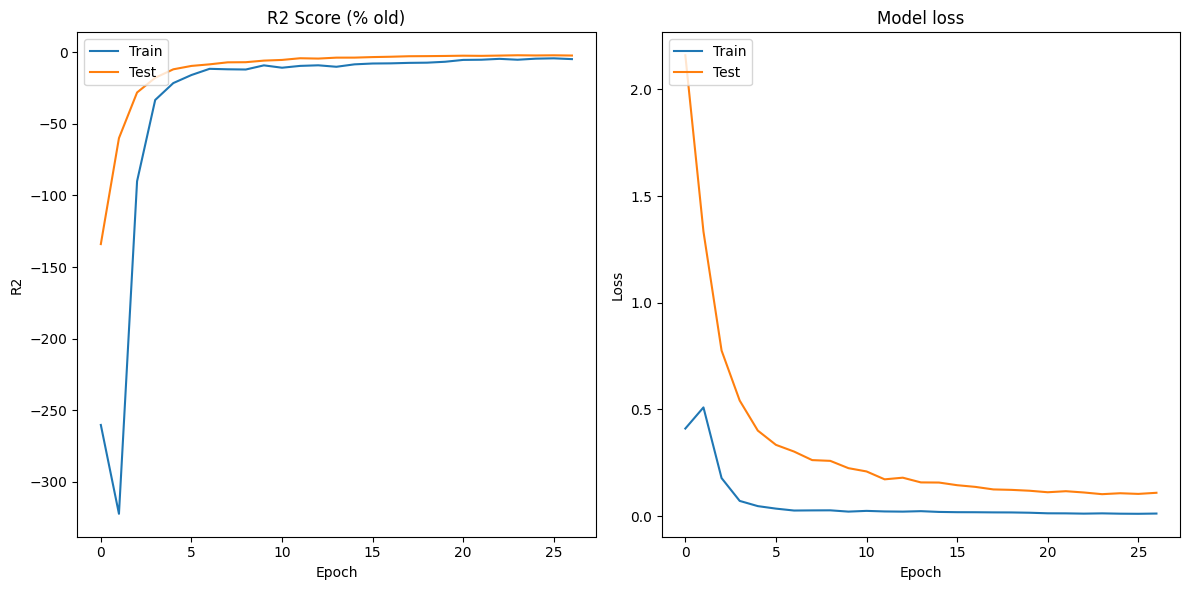

In [426]:
plot_history(history)

In [26]:
meta_clf_c = get_wb_meta_clf(adv_inputs_c)

In [27]:
meta_clf_c.load_weights("cifar/models/manual_checkpoints/wb-meta/best.weights.h5")

In [28]:
meta_clf_c.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.MeanAbsoluteError(), metrics=[keras.metrics.R2Score()])

In [24]:
ds_test_cifar = tf.data.Dataset.load("cifar/data/white-box/test-data").batch(8)

In [29]:
meta_clf_c.evaluate(ds_test_cifar)

57/57 ━━━━━━━━━━━━━━━━━━━━ 64s 63ms/step - loss: 0.2028 - r2_score: -7201462.5000


[0.129729762673378, 0.5728048086166382]

In [30]:
meta_clf_c.save_weights("cifar/models/wb_meta_0.57_test_r2.weights.h5")

# UTKFace Whitebox

In [1]:
import keras
from common.whitebox_utils import do_read_single_model_params

utk_base_path = "utkface/models/shadow_models"
m_utk = keras.models.load_model(f'{utk_base_path}/0.1/train/0.keras')
adv_inputs = do_read_single_model_params(m_utk)

2024-04-28 23:07:58.466305: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 23:07:58.474009: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 23:08:25.711069: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
from common.whitebox_utils import get_dataset

ds_utk = get_dataset(200, utk_base_path, 'train')
ds_test_utk = get_dataset(50, utk_base_path, 'test')

In [2]:
import tensorflow as tf

ds_utk = tf.data.Dataset.load("utkface/data/white-box/train-data")
ds_test_utk = tf.data.Dataset.load("utkface/data/white-box/test-data")

In [3]:
ds_utk_batched = ds_utk.shuffle(1800).batch(32, drop_remainder=True)
ds_test_utk_batched = ds_test_utk.batch(8)

In [8]:
meta_clf = get_wb_meta_clf(adv_inputs)

In [9]:
#meta_clf = keras.models.load_model("wb-meta.keras")
meta_clf.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.MeanAbsoluteError(), metrics=[keras.metrics.R2Score()])

In [11]:
round(0.333, 2)

0.33

In [31]:
checkpoint_filepath = "utkface/models/manual_checkpoints/wb-meta/best.weights.h5"

currentmax = 0.4
for i in range(50):
    meta_clf = get_wb_meta_clf(adv_inputs)
    meta_clf.compile(optimizer=keras.optimizers.SGD(), loss=keras.losses.MeanAbsoluteError(), metrics=[keras.metrics.R2Score()])
    history = meta_clf.fit(
        ds_utk_batched, 
        epochs=70, 
        validation_data=ds_test_utk_batched, 
        callbacks=[
            keras.callbacks.EarlyStopping('val_r2_score', patience=5),
            keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='val_r2_score',
                mode='max',
                save_best_only=True)
        ])
    newmax = max(history.history['val_r2_score'])
    if newmax > currentmax:
        print(f"new max r2: {newmax}")
        currentmax = newmax
        meta_clf.load_weights("utkface/models/manual_checkpoints/wb-meta/best.weights.h5")
        meta_clf.save_weights(f"utkface/models/wb_adv_utk_{round(newmax, 2)}_test_r2.keras")

Epoch 1/70


2024-04-28 23:34:22.892974: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 523 of 1800
2024-04-28 23:34:41.961480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - loss: 0.8466 - r2_score: -16.8000 - val_loss: 1.3914 - val_r2_score: -30.1328
Epoch 2/70


2024-04-28 23:36:09.435603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 531 of 1800
2024-04-28 23:36:19.438183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1173 of 1800
2024-04-28 23:36:28.628090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 589ms/step - loss: 0.4989 - r2_score: -5.0879 - val_loss: 0.8943 - val_r2_score: -12.9358
Epoch 3/70


2024-04-28 23:37:11.659403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 679 of 1800
2024-04-28 23:37:31.664402: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1772 of 1800
2024-04-28 23:37:32.076967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 541ms/step - loss: 0.3769 - r2_score: -2.4915 - val_loss: 0.6398 - val_r2_score: -6.6549
Epoch 4/70


2024-04-28 23:38:12.371000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 542 of 1800
2024-04-28 23:38:22.375956: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1157 of 1800
2024-04-28 23:38:31.810814: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 570ms/step - loss: 0.2869 - r2_score: -1.1008 - val_loss: 0.4875 - val_r2_score: -3.6409
Epoch 5/70


2024-04-28 23:39:14.021796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 675 of 1800
2024-04-28 23:39:33.456993: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 525ms/step - loss: 0.2474 - r2_score: -0.4720 - val_loss: 0.3730 - val_r2_score: -1.8038
Epoch 6/70


2024-04-28 23:40:13.257465: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 621 of 1800
2024-04-28 23:40:31.810648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 621ms/step - loss: 0.2007 - r2_score: 0.0035 - val_loss: 0.2599 - val_r2_score: -0.4571
Epoch 7/70


2024-04-28 23:41:16.536946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 645 of 1800
2024-04-28 23:41:35.765597: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 565ms/step - loss: 0.1827 - r2_score: 0.2088 - val_loss: 0.1939 - val_r2_score: 0.1448
Epoch 8/70


2024-04-28 23:42:17.870679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 557 of 1800
2024-04-28 23:42:37.057863: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 578ms/step - loss: 0.1464 - r2_score: 0.4985 - val_loss: 0.1379 - val_r2_score: 0.5432
Epoch 9/70


2024-04-28 23:43:19.507563: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 574 of 1800
2024-04-28 23:43:29.509498: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1207 of 1800
2024-04-28 23:43:39.510333: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1707 of 1800
2024-04-28 23:43:41.383988: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 55s 412ms/step - loss: 0.1414 - r2_score: 0.5261 - val_loss: 0.1457 - val_r2_score: 0.4929
Epoch 10/70


2024-04-28 23:44:14.641775: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 599 of 1800
2024-04-28 23:44:24.649523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1145 of 1800
2024-04-28 23:44:34.439610: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 580ms/step - loss: 0.1346 - r2_score: 0.5685 - val_loss: 0.1148 - val_r2_score: 0.6675
Epoch 11/70


2024-04-28 23:45:17.334004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 634 of 1800
2024-04-28 23:45:27.335668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1311 of 1800
2024-04-28 23:45:35.256280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 610ms/step - loss: 0.1220 - r2_score: 0.6406 - val_loss: 0.0950 - val_r2_score: 0.7757
Epoch 12/70


2024-04-28 23:46:19.847634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 608 of 1800
2024-04-28 23:46:39.290115: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 57s 482ms/step - loss: 0.1221 - r2_score: 0.6459 - val_loss: 0.1209 - val_r2_score: 0.6320
Epoch 13/70


2024-04-28 23:47:16.356395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 526 of 1800
2024-04-28 23:47:26.358636: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1241 of 1800
2024-04-28 23:47:35.061071: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 544ms/step - loss: 0.1206 - r2_score: 0.6537 - val_loss: 0.1087 - val_r2_score: 0.7003
Epoch 14/70


2024-04-28 23:48:15.804651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 530 of 1800
2024-04-28 23:48:35.789675: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1646 of 1800
2024-04-28 23:48:37.846254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 535ms/step - loss: 0.1127 - r2_score: 0.6629 - val_loss: 0.0882 - val_r2_score: 0.8014
Epoch 15/70


2024-04-28 23:49:18.163004: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 550 of 1800
2024-04-28 23:49:36.692536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 59s 539ms/step - loss: 0.1078 - r2_score: 0.7059 - val_loss: 0.1224 - val_r2_score: 0.6293
Epoch 16/70


2024-04-28 23:50:17.383809: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 646 of 1800
2024-04-28 23:50:27.388311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1095 of 1800
2024-04-28 23:50:37.391952: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1495 of 1800
2024-04-28 23:50:43.561021: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 65s 498ms/step - loss: 0.1096 - r2_score: 0.7068 - val_loss: 0.0829 - val_r2_score: 0.8293
Epoch 17/70


2024-04-28 23:51:21.326146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 597 of 1800
2024-04-28 23:51:31.326312: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1232 of 1800
2024-04-28 23:51:39.053583: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 56s 502ms/step - loss: 0.1008 - r2_score: 0.7413 - val_loss: 0.0898 - val_r2_score: 0.7834
Epoch 18/70


2024-04-28 23:52:18.111345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 659 of 1800
2024-04-28 23:52:35.824467: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 581ms/step - loss: 0.0957 - r2_score: 0.7732 - val_loss: 0.0784 - val_r2_score: 0.8452
Epoch 19/70


2024-04-28 23:53:18.790305: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 460 of 1800
2024-04-28 23:53:38.788536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1642 of 1800
2024-04-28 23:53:41.173584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 68s 631ms/step - loss: 0.0965 - r2_score: 0.7595 - val_loss: 0.0764 - val_r2_score: 0.8532
Epoch 20/70


2024-04-28 23:54:26.506959: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 732 of 1800
2024-04-28 23:54:36.515112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1255 of 1800
2024-04-28 23:54:45.546778: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 53s 417ms/step - loss: 0.1026 - r2_score: 0.7314 - val_loss: 0.0985 - val_r2_score: 0.7416
Epoch 21/70


2024-04-28 23:55:19.313964: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 668 of 1800
2024-04-28 23:55:39.317819: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1798 of 1800
2024-04-28 23:55:39.345581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 60s 538ms/step - loss: 0.1054 - r2_score: 0.7161 - val_loss: 0.0746 - val_r2_score: 0.8632
Epoch 22/70


2024-04-28 23:56:19.959395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 560 of 1800
2024-04-28 23:56:39.952247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1769 of 1800
2024-04-28 23:56:40.535584: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 527ms/step - loss: 0.1007 - r2_score: 0.7383 - val_loss: 0.0944 - val_r2_score: 0.7623
Epoch 23/70


2024-04-28 23:57:20.053729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 699 of 1800
2024-04-28 23:57:37.391576: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 51s 419ms/step - loss: 0.0974 - r2_score: 0.7631 - val_loss: 0.0768 - val_r2_score: 0.8435
Epoch 24/70


2024-04-28 23:58:11.668750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 430 of 1800
2024-04-28 23:58:31.646854: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1544 of 1800
2024-04-28 23:58:35.367918: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 64s 533ms/step - loss: 0.0901 - r2_score: 0.7914 - val_loss: 0.0741 - val_r2_score: 0.8627
Epoch 25/70


2024-04-28 23:59:15.744349: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 541 of 1800
2024-04-28 23:59:25.753361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1047 of 1800
2024-04-28 23:59:43.346226: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 63s 447ms/step - loss: 0.0934 - r2_score: 0.7776 - val_loss: 0.0732 - val_r2_score: 0.8595
Epoch 26/70


2024-04-29 00:00:18.892917: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 445 of 1800
2024-04-29 00:00:38.875482: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1618 of 1800
2024-04-29 00:00:41.816553: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 507ms/step - loss: 0.0920 - r2_score: 0.7897 - val_loss: 0.0935 - val_r2_score: 0.7603
new max r2: 0.8632043600082397


ValueError: The filename must end in `.weights.h5`. Received: filepath=utkface/models/wb_adv_utk_0.86_test_r2.keras

In [32]:
meta_clf.save_weights(f"utkface/models/wb_adv_utk_{round(newmax, 2)}_test_r2.weights.h5")

In [ ]:
meta_clf.evaluate(ds_test_utk_batched)

25/57 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 0.0370 - r2_score: -120790.7266

In [40]:
print("Hi")

Hi


In [41]:
from cifar_functions import get_cifar_input_set
asdf = get_cifar_input_set()
asdf.shape

(5040, 32, 32, 3)